<a href="https://colab.research.google.com/github/SanjayanAri/Bulk_RNA_seq/blob/main/DESeq2_workflow_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Notebook for gene expression analysis using DESeq2 to determine the genes upregulated by hypoxia in both LNCaP and PC3 cells in different condition (Hypoxia and Normoxia).

paper reference: https://pmc.ncbi.nlm.nih.gov/articles/PMC6336817/#Sec11

Author: Sanjayan.A

What are the things needed:
count matrix from feature counts data (combined of all the 8 sample's matrix) and annotation of the genome from ensemble biomart (version: GrCh38.p14) in csv format.

analysis will begin once the prechecks are done.

# Prechecks

There are some packages already available in the google collab but remaining all are needed to be installed and loaded for (e.g) bioconductor packages, and few more packages, this is a time taking process and will have to be ran every time when you start the runtime engine.

In [8]:
#some packages needed to be installed and loaded
install.packages("pheatmap")
install.packages("ggrepel")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [9]:
#loading libraries
library(tidyverse)
library(dplyr)
library(tibble)
library(data.table)
library(ggplot2)
library(scales)
library(stats)
library(RColorBrewer)

In [10]:
library(pheatmap)
library(ggrepel)

In [5]:
# now to load the bioconductor packages takes 25 mins to load
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("DESeq2")
BiocManager::install("clusterProfiler")
BiocManager::install("org.Hs.eg.db")
BiocManager::install("ReactomePA")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.21 (BiocManager 1.30.26), R 4.5.1 (2025-06-13)

Installing package(s) 'BiocVersion', 'DESeq2'

also installing the dependencies ‘formatR’, ‘UCSC.utils’, ‘GenomeInfoDbData’, ‘abind’, ‘SparseArray’, ‘lambda.r’, ‘futile.options’, ‘GenomeInfoDb’, ‘XVector’, ‘S4Arrays’, ‘DelayedArray’, ‘futile.logger’, ‘snow’, ‘BH’, ‘S4Vectors’, ‘IRanges’, ‘GenomicRanges’, ‘SummarizedExperiment’, ‘BiocGenerics’, ‘Biobase’, ‘BiocParallel’, ‘matrixStats’, ‘locfit’, ‘MatrixGenerics’, ‘RcppArmadillo’


Old packages: 'later', 'xml2'

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.

In [ ]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("fgsea")

In [11]:
library(fgsea)

In [52]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("edgeR")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.21 (BiocManager 1.30.26), R 4.5.1 (2025-06-13)

Installing package(s) 'edgeR'

also installing the dependencies ‘statmod’, ‘limma’


Old packages: 'later', 'xml2'



In [12]:
library(DESeq2)
library(clusterProfiler)
library(org.Hs.eg.db)
library(ReactomePA)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: generics


Attaching package: ‘generics’


The following object is masked from ‘package:lubridate’:

    as.difftime


The following object is masked from ‘package:dplyr’:

    explain


The following objects are masked from ‘package:base’:

    as.difftime, as.factor, as.ordered, intersect, is.element, setdiff,
    setequal, union



Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:dplyr’:

    combine


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbin

In [13]:
setwd("/content")

Now to uploading the files, upload both counts matrix and the gene annotation file, in the directory of your choice but remeber the path should be given, you can upload it in the "/content folder too.

note: files will be removed when you exit the console so you have to re-upload again

# Analysis

## Loading the sample

Loading the count matrix

The matrix here is loaded as raw_counts and then the raw_counts are sorted by coloumn names

In [14]:
raw_counts <- read.csv("/content/GSE106305_counts_matrix.csv", header = TRUE, row.names = "Geneid", stringsAsFactors = FALSE)
head(raw_counts)
raw_counts <- raw_counts[,sort(colnames(raw_counts))]
colSums(raw_counts)

,PC3_Normoxia_S2,PC3_Normoxia_S1,LNCAP_Hypoxia_S1,LNCAP_Normoxia_S1,LNCAP_Normoxia_S2,LNCAP_Hypoxia_S2,PC3_Hypoxia_S1,PC3_Hypoxia_S2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,971,352,604,367,380,691,1059,332
ENSG00000000005,0,0,0,0,0,0,0,0
ENSG00000000419,1761,747,1995,2160,2454,2302,1974,693
ENSG00000000457,83,29,554,433,518,607,88,26
ENSG00000000460,438,189,275,379,349,350,390,155
ENSG00000000938,1,0,2,2,1,2,0,0


LNCAP_Hypoxia_S1  LNCAP_Hypoxia_S2 LNCAP_Normoxia_S1 LNCAP_Normoxia_S2 
         35704166          40621020          38248079          46410377 
   PC3_Hypoxia_S1    PC3_Hypoxia_S2   PC3_Normoxia_S1   PC3_Normoxia_S2 
         36884034          12629190          12917473          38077845

We observe that each sample has been sequenced at a different “depth”, in which there are varying numbers of total reads for each sample. Hence we need to normalize this data.

After the data have been processed using DESeq2, we will have normalized data that we can use to make comparisons.

In [15]:
# find biological replicates for making DESeq2 object to normalize the data
condition <- c(rep("LNCAP_Hypoxia", 2), rep("LNCAP_Normoxia", 2), rep("PC3_Hypoxia", 2), rep("PC3_Normoxia", 2))
print(condition)

[1] "LNCAP_Hypoxia"  "LNCAP_Hypoxia"  "LNCAP_Normoxia" "LNCAP_Normoxia"
[5] "PC3_Hypoxia"    "PC3_Hypoxia"    "PC3_Normoxia"   "PC3_Normoxia"  


In [16]:
# assign replicates to each sample name to construct colData
my_colData <- as.data.frame(condition)
rownames(my_colData) <- colnames(raw_counts)
my_colData

,condition
,<chr>
LNCAP_Hypoxia_S1,LNCAP_Hypoxia
LNCAP_Hypoxia_S2,LNCAP_Hypoxia
LNCAP_Normoxia_S1,LNCAP_Normoxia
LNCAP_Normoxia_S2,LNCAP_Normoxia
PC3_Hypoxia_S1,PC3_Hypoxia
PC3_Hypoxia_S2,PC3_Hypoxia
PC3_Normoxia_S1,PC3_Normoxia
PC3_Normoxia_S2,PC3_Normoxia


Above you see this the sample and the condition like a meta data

## Making the DESeq2 object and annotation

The vector above named condition can be used for the design argument. Now that we have all the required inputs, we will create a DESeq2 object (usually named dds) using DESeqDataSetFromMatrix():

In [17]:
dds <- DESeqDataSetFromMatrix(countData = as.matrix(raw_counts),
                              colData = my_colData,
                              design = ~condition)
dds

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 78894 8 
metadata(1): version
assays(1): counts
rownames(78894): ENSG00000000003 ENSG00000000005 ... ENSG00000310576
  ENSG00000310577
rowData names(0):
colnames(8): LNCAP_Hypoxia_S1 LNCAP_Hypoxia_S2 ... PC3_Normoxia_S1
  PC3_Normoxia_S2
colData names(1): condition

In [18]:
head(counts(dds))
dim(counts(dds))

,LNCAP_Hypoxia_S1,LNCAP_Hypoxia_S2,LNCAP_Normoxia_S1,LNCAP_Normoxia_S2,PC3_Hypoxia_S1,PC3_Hypoxia_S2,PC3_Normoxia_S1,PC3_Normoxia_S2
ENSG00000000003,604,691,367,380,1059,332,352,971
ENSG00000000005,0,0,0,0,0,0,0,0
ENSG00000000419,1995,2302,2160,2454,1974,693,747,1761
ENSG00000000457,554,607,433,518,88,26,29,83
ENSG00000000460,275,350,379,349,390,155,189,438
ENSG00000000938,2,2,2,1,0,0,0,1


[1] 78894     8

Data quality control and filtering diagnostic step. Its primary purpose is to understand how many genes in your dataset are lowly expressed or completely silent (have zero counts).

In [19]:
count_matrix <- counts(dds)
dim(count_matrix)
zero_counts_per_gene <- rowSums(count_matrix == 0)
count_matrix <- as.data.frame(count_matrix)
zero_summary <- table(zero_counts_per_gene)
print(zero_summary)

[1] 78894     8

zero_counts_per_gene
    0     1     2     3     4     5     6     7     8 
19522  3391  2972  3281  5019  3858  4632  7435 28784 


You see here the zero counts of genes present in samples is found,To understand this first we made a logic in the zero_counts_per_gene (count_matrix == 0) where True = 0 and false = where the counts are non zero. These are added (rowsums) and summarized.

so we see here 19522 gene are no zeros means expressed in all and 28,784 gene are not expressed in any samples.

Now to download the annotation file from the ensemble biomart, choose the latest version and then pick the attributes for gene name gene ID gene type and download the unique only version in csv file format and use as mentioned above

In [20]:
annotation_file <- "/content/Gene_ann_GrCh38.p14.csv"
annotation <- read.csv(annotation_file, stringsAsFactors = FALSE)
counts_gse <- read.csv("/content/GSE106305_counts_matrix.csv",
                     header = TRUE,
                     stringsAsFactors = FALSE)

In [21]:
annotation_file <- "/content/Gene_ann_GrCh38.p14.csv"
annotation_check <- read.csv(annotation_file, stringsAsFactors = FALSE)

print("Column names of the annotation dataframe:")
print(colnames(annotation_check))

print("Head of the annotation dataframe:")
print(head(annotation_check))

[1] "Column names of the annotation dataframe:"
[1] "Gene.stable.ID" "Gene.name"      "Gene.type"     
[1] "Head of the annotation dataframe:"
   Gene.stable.ID Gene.name      Gene.type
1 ENSG00000210049     MT-TF        Mt_tRNA
2 ENSG00000211459   MT-RNR1        Mt_rRNA
3 ENSG00000210077     MT-TV        Mt_tRNA
4 ENSG00000210082   MT-RNR2        Mt_rRNA
5 ENSG00000209082    MT-TL1        Mt_tRNA
6 ENSG00000198888    MT-ND1 protein_coding


our annotation file contains gene.stable.ID, gene.name, gene.type as the columns. Noticed our own count matrix also has the same gene ID, this is the common thing between the two files.

In [22]:
counts_gse$Geneid <- sub("\\..*$", "", counts_gse$Geneid)
annotation$Gene.stable.ID <- sub("\\..*$", "", annotation$Gene.stable.ID)

# check for the columns
print("Head of counts_gse$Geneid after modification:")
print(head(counts_gse$Geneid))
print("Head of annotation$Gene.stable.ID after modification:")
print(head(annotation$Gene.stable.ID))

[1] "Head of counts_gse$Geneid after modification:"
[1] "ENSG00000000003" "ENSG00000000005" "ENSG00000000419" "ENSG00000000457"
[5] "ENSG00000000460" "ENSG00000000938"
[1] "Head of annotation$Gene.stable.ID after modification:"
[1] "ENSG00000210049" "ENSG00000211459" "ENSG00000210077" "ENSG00000210082"
[5] "ENSG00000209082" "ENSG00000198888"


Now we know that the ID is common part here and we have to join the data to one file, this is called joint.

A join combines two data frames (tables) based on a common column (like an ID in this case)

Keeps all rows from the left table -> left joint

Keeps all rows from the right table -> right joint

In [23]:
annotated_counts <- left_join(counts_gse, annotation, by = c("Geneid" = "Gene.stable.ID")) %>%
  dplyr::select(Geneid, Gene.name, Gene.type,
         LNCAP_Hypoxia_S1, LNCAP_Hypoxia_S2, LNCAP_Normoxia_S1, LNCAP_Normoxia_S2,
         PC3_Hypoxia_S1, PC3_Hypoxia_S2, PC3_Normoxia_S1, PC3_Normoxia_S2)

head(annotated_counts)

,Geneid,Gene.name,Gene.type,LNCAP_Hypoxia_S1,LNCAP_Hypoxia_S2,LNCAP_Normoxia_S1,LNCAP_Normoxia_S2,PC3_Hypoxia_S1,PC3_Hypoxia_S2,PC3_Normoxia_S1,PC3_Normoxia_S2
,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ENSG00000000003,TSPAN6,protein_coding,604,691,367,380,1059,332,352,971
2,ENSG00000000005,TNMD,protein_coding,0,0,0,0,0,0,0,0
3,ENSG00000000419,DPM1,protein_coding,1995,2302,2160,2454,1974,693,747,1761
4,ENSG00000000457,SCYL3,protein_coding,554,607,433,518,88,26,29,83
5,ENSG00000000460,FIRRM,protein_coding,275,350,379,349,390,155,189,438
6,ENSG00000000938,FGR,protein_coding,2,2,2,1,0,0,0,1


Joint is done now since we joined both the tables the data is one frame now, since annotated we will also have things like pseudo genes and other stuffs we don't need for the analysis, so have to filter out the biotypes.

## Filtering the data

In [24]:
#Adding the necessary biotypes needed for filtering
biotypes_to_keep <- c("protein_coding", "IG_J_gene", "IG_V_gene", "IG_C_gene", "IG_D_gene", "TR_D_gene", "TR_C_gene", "TR_V_gene", "TR_J_gene")

Above we segregate the biotypes we neeed, we created a vector (biotypes_to_keep) for it and we are using that to filter the data frame.

In [25]:
filtered_counts <- annotated_counts %>%
  filter(Gene.type %in% biotypes_to_keep)

filtered_counts$Geneid <- sub("\\..*$", "", filtered_counts$Geneid)
head(filtered_counts, n = 3)

output_file <- "9biotype_count_matrix.csv"
fwrite(filtered_counts, file = output_file, sep = ",", row.names = FALSE)
zero_counts1 <- rowSums(filtered_counts[, 4:11] == 0)
zero_summary2 <- table(zero_counts1)
print(zero_summary2)

,Geneid,Gene.name,Gene.type,LNCAP_Hypoxia_S1,LNCAP_Hypoxia_S2,LNCAP_Normoxia_S1,LNCAP_Normoxia_S2,PC3_Hypoxia_S1,PC3_Hypoxia_S2,PC3_Normoxia_S1,PC3_Normoxia_S2
,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ENSG00000000003,TSPAN6,protein_coding,604,691,367,380,1059,332,352,971
2,ENSG00000000005,TNMD,protein_coding,0,0,0,0,0,0,0,0
3,ENSG00000000419,DPM1,protein_coding,1995,2302,2160,2454,1974,693,747,1761


zero_counts1
    0     1     2     3     4     5     6     7     8 
13344   845   674   713   963   507   505   742  2239 


After filtering the biotypes with the vector and then making a data frame we are checking again the number of zero count genes present after filtering.

Now we are going to filter out the gene counts which are not available in more than 6 of the samples.

In [26]:
keep_genes <- zero_counts1 < 7
filtered_counts_nozero <- filtered_counts[keep_genes, ]
cat("Number of genes after filtering (zeros in <7 samples):", nrow(filtered_counts_nozero), "\n")

new_zero_counts <- rowSums(filtered_counts_nozero[, 4:11] == 0)
cat("New zero counts distribution:\n")
print(table(new_zero_counts))

output_file <- "filtered_biotype_nozero_count_matrix.csv"
fwrite(filtered_counts_nozero, file = output_file, sep = ",", row.names = FALSE)

head(filtered_counts_nozero, n = 3)

Number of genes after filtering (zeros in <7 samples): 17551 
New zero counts distribution:
new_zero_counts
    0     1     2     3     4     5     6 
13344   845   674   713   963   507   505 


,Geneid,Gene.name,Gene.type,LNCAP_Hypoxia_S1,LNCAP_Hypoxia_S2,LNCAP_Normoxia_S1,LNCAP_Normoxia_S2,PC3_Hypoxia_S1,PC3_Hypoxia_S2,PC3_Normoxia_S1,PC3_Normoxia_S2
,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ENSG00000000003,TSPAN6,protein_coding,604,691,367,380,1059,332,352,971
3,ENSG00000000419,DPM1,protein_coding,1995,2302,2160,2454,1974,693,747,1761
4,ENSG00000000457,SCYL3,protein_coding,554,607,433,518,88,26,29,83


In [27]:
filtered_counts_nozero <- filtered_counts[keep_genes, ]
cat("Number of genes after filtering (zeros in <7 samples):", nrow(filtered_counts_nozero), "\n")

Number of genes after filtering (zeros in <7 samples): 17551 


In [28]:
new_zero_counts <- rowSums(filtered_counts_nozero[, 4:11] == 0)
print(table(new_zero_counts))

output_file <- "filtered_biotype_6.csv"
fwrite(filtered_counts_nozero, file = output_file, sep = ",", row.names = FALSE)

head(filtered_counts_nozero, n = 3)

dds_filtered <- dds[rownames(dds) %in% filtered_counts_nozero$Geneid, ]

new_zero_counts
    0     1     2     3     4     5     6 
13344   845   674   713   963   507   505 


,Geneid,Gene.name,Gene.type,LNCAP_Hypoxia_S1,LNCAP_Hypoxia_S2,LNCAP_Normoxia_S1,LNCAP_Normoxia_S2,PC3_Hypoxia_S1,PC3_Hypoxia_S2,PC3_Normoxia_S1,PC3_Normoxia_S2
,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ENSG00000000003,TSPAN6,protein_coding,604,691,367,380,1059,332,352,971
3,ENSG00000000419,DPM1,protein_coding,1995,2302,2160,2454,1974,693,747,1761
4,ENSG00000000457,SCYL3,protein_coding,554,607,433,518,88,26,29,83


In [29]:
biotype_table <- table(filtered_counts_nozero$Gene.type)
biotype_counts <- data.frame(
  Biotype = names(biotype_table),
  n = as.numeric(biotype_table),
  stringsAsFactors = FALSE
)

biotype_counts$Proportion <- biotype_counts$n / sum(biotype_counts$n)
biotype_counts$Percentage <- biotype_counts$Proportion * 100

print(biotype_counts)

         Biotype     n   Proportion  Percentage
1      IG_C_gene     9 0.0005127913  0.05127913
2      IG_D_gene     4 0.0002279072  0.02279072
3      IG_V_gene    10 0.0005697681  0.05697681
4 protein_coding 17491 0.9965813914 99.65813914
5      TR_C_gene     6 0.0003418609  0.03418609
6      TR_J_gene     9 0.0005127913  0.05127913
7      TR_V_gene    22 0.0012534898  0.12534898


The propotion of the biotypes in the data frame is found by the above chunk of command, we see protein_coding genes are in highest propotion and the number. we can create a plot of the propotion values just to visualize

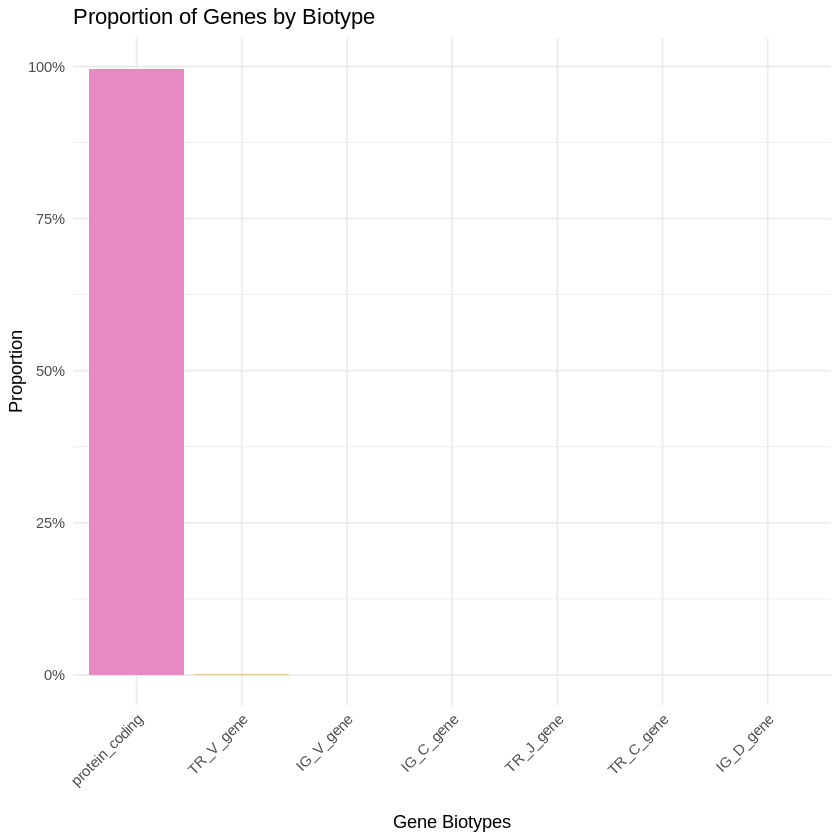

In [30]:
p <- ggplot(biotype_counts, aes(x = reorder(Biotype, -Proportion), y = Proportion, fill = Biotype)) +
  geom_bar(stat = "identity") +
  labs(title = "Proportion of Genes by Biotype",
       x = "Gene Biotypes",
       y = "Proportion") +
  scale_y_continuous(labels = scales::percent_format(scale = 100)) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        legend.position = "none") +
  scale_fill_brewer(palette = "Set2")
p
output_plot <- "genebiotype_proportions1.png"
ggsave(output_plot, plot = p, width = 8, height = 6, dpi = 300)

# Visualization for variability

visualizing the obtained dataframe for the analysis.

In [31]:
dds <- DESeq(dds_filtered)
dds
normalized_counts <- counts(dds, normalized = T)
normalized_counts_df <- as.data.frame(normalized_counts)
write.csv(normalized_counts_df, file = "normalized_counts.csv", row.names = TRUE)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



class: DESeqDataSet 
dim: 17551 8 
metadata(1): version
assays(4): counts mu H cooks
rownames(17551): ENSG00000000003 ENSG00000000419 ... ENSG00000310560
  ENSG00000310576
rowData names(30): baseMean baseVar ... deviance maxCooks
colnames(8): LNCAP_Hypoxia_S1 LNCAP_Hypoxia_S2 ... PC3_Normoxia_S1
  PC3_Normoxia_S2
colData names(2): condition sizeFactor

Object dds after filtering is normalized for the sequencing depth and the read mapped.  

### Distance Plot

The distance plot calculates the Euclidean distance between the expression values for each individual sample. This is a way to identify which samples are most closely related in terms of their gene expression patterns.

png 
  3

png 
  3

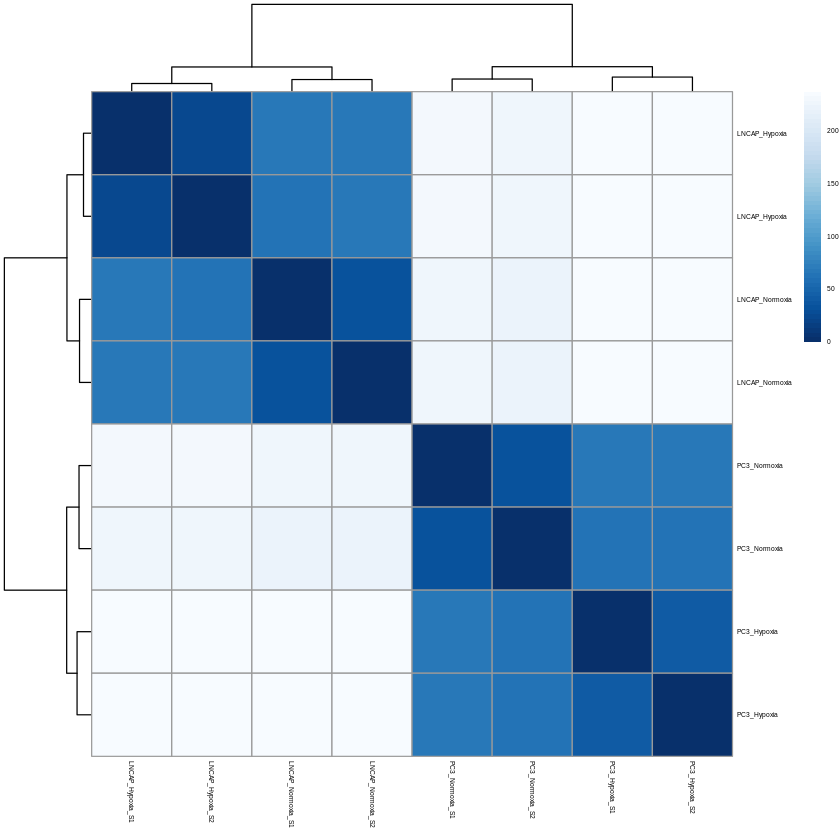

In [32]:
#Distance plot
vsd <- vst(dds, blind = TRUE)
plotDists = function (vsd.obj) {
  sampleDists <- dist(t(assay(vsd.obj)))
  sampleDistMatrix <- as.matrix(sampleDists)
  rownames(sampleDistMatrix) <- paste(vsd.obj$condition)
  colors <- colorRampPalette(rev(RColorBrewer::brewer.pal(9, "Blues")))(55)
  pheatmap::pheatmap(sampleDistMatrix, clustering_distance_rows = sampleDists,  clustering_distance_cols = sampleDists, col = colors, fontsize_row = 4, fontsize_col = 4, fontsize_legend = 4, fontsize = 4)
}
png(filename = "Distance_plot.png", width = 1000, height = 900, res = 300)
plotDists(vsd)
dev.off()

pdf(file = "Distance_plot.pdf", width = 7, height = 6)
plotDists(vsd)
dev.off()

Darker blue squares indicate samples that are more similar to each other.

Lighter blue squares indicate samples that are less similar.

we can observe that the replicates within each condition (such as, LNCAP_Hypoxia_S1 and LNCAP_Hypoxia_S2) are more similar to each other (darker blue) than they are to samples from different conditions. This suggests that the biological condition is a major driver of the gene expression differences between the samples.

### PCA plots

A principal components plot is another way to observe how diverse the samples are. As always, the samples which are most similar with each other in terms of their gene expression values will be closer to each other on the plot. This plot uses a Cartesian coordinate system, and the axes that are displayed correspond to the top two principal components that explain the majority of the variability in the data.

In [33]:
vsd <- vst(dds_filtered, blind = TRUE)
plot_PCA = function (vsd.obj) {
  pcaData <- plotPCA(vsd.obj,  intgroup = c("condition"), returnData = T)
  percentVar <- round(100 * attr(pcaData, "percentVar"))
  ggplot(pcaData, aes(PC1, PC2, color=condition)) +
    geom_point(size=3) +
    labs(x = paste0("PC1: ",percentVar[1],"% variance"),
         y = paste0("PC2: ",percentVar[2],"% variance"),
         title = "PCA Plot colored by condition") +
    ggrepel::geom_text_repel(aes(label = name), color = "black")
}

png(filename = "pca1.png",
    width = 2000, height = 2000, res = 300)
plot_PCA(vsd)
dev.off()

using ntop=500 top features by variance



agg_record_843071660 
                   2

We observe that The LNCaP samples are furthest separated from the PC3 samples on the x-axis (PC1), which explains a whopping 99% of the variance in the dataset. Within each cell type, the normoxia samples are separated from the hypoxia samples. The amount of variability introduced by hypoxia is small compared to the inherent difference between the LNCaP and PC3 cell lines.
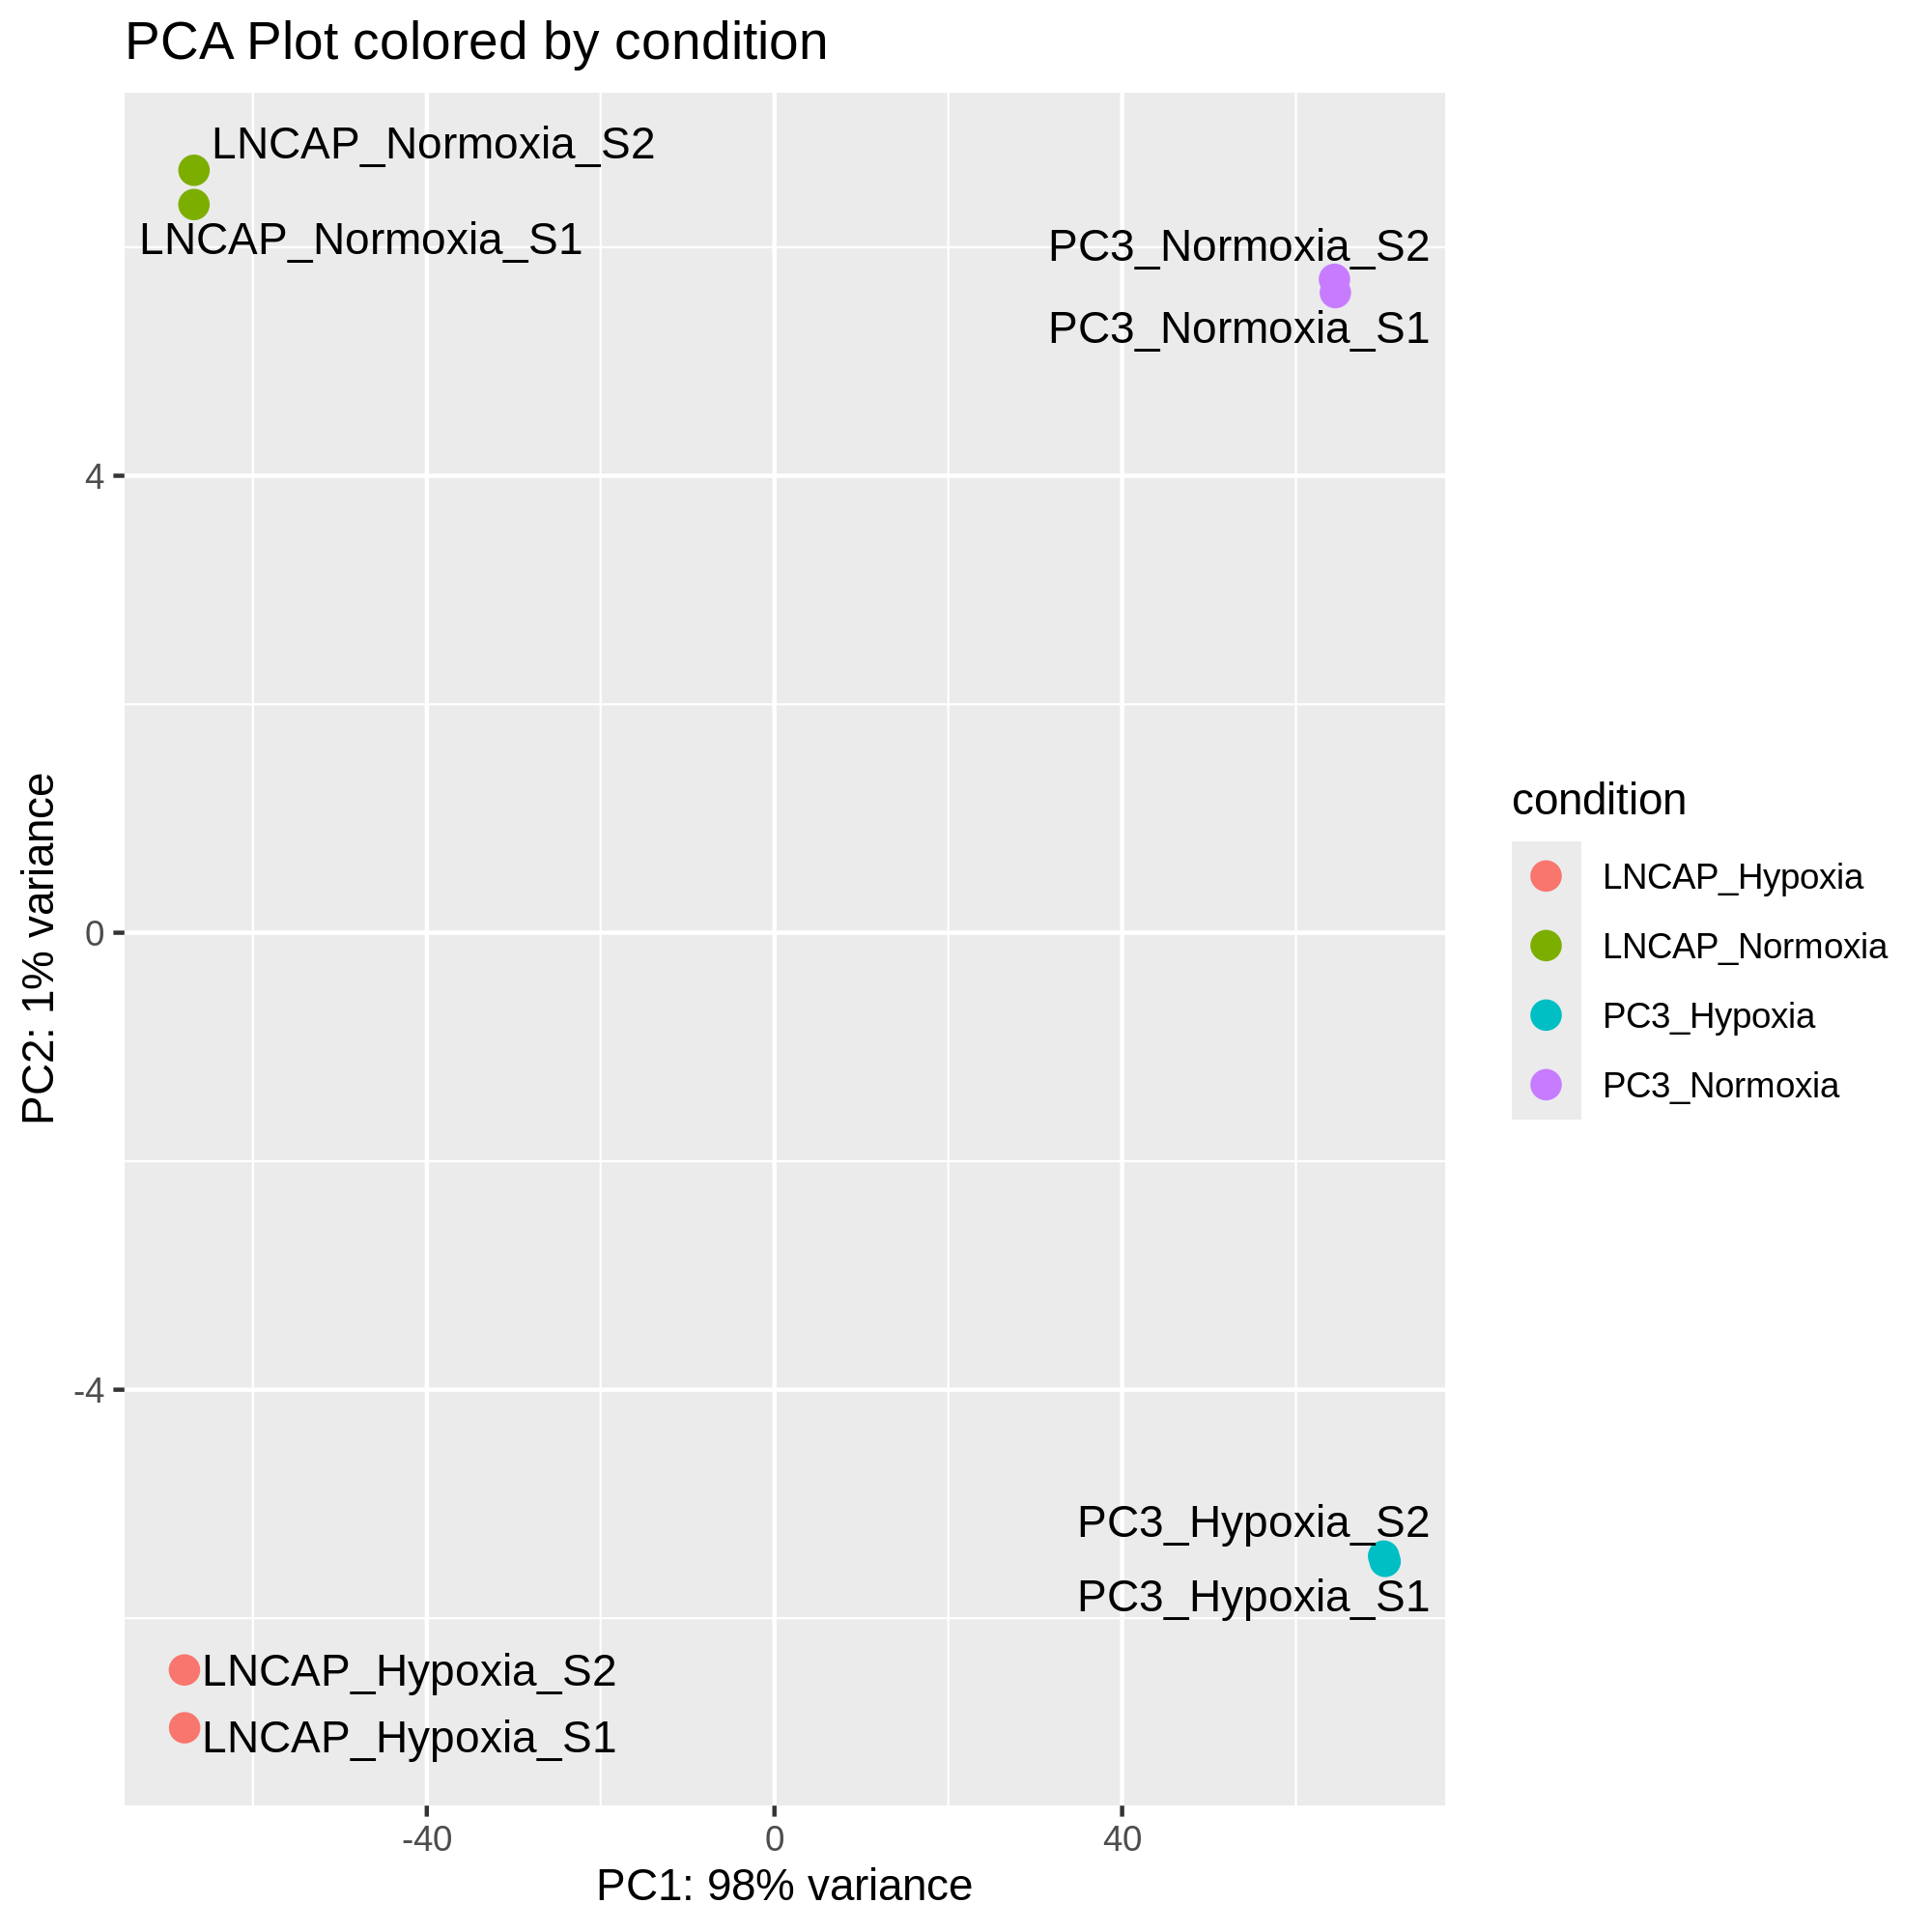

### Variable genes Heat map

We can identify the genes that are driving the clustering between samples and display them in a heatmap. To do so, we first obtain the top most variable genes across samples by selecting the genes with the highest rowVars() value. Then, we plug the normalized counts for these genes into a heatmap using pheatmap::pheatmap(). The heatmap will cluster the samples based on expression similarity as well as display the genes that are associated with each cluster on the right-hand side. Note that the genes are simply chosen based on variability across samples.

png 
  3

[1] 17551     8

png 
  3

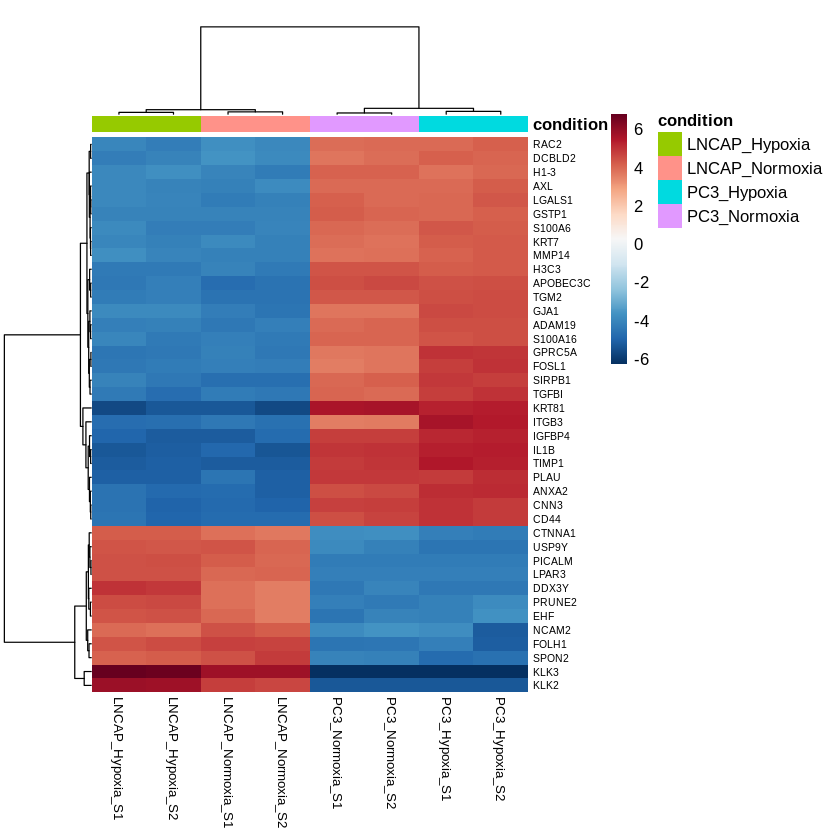

In [34]:
variable_gene_heatmap <- function (vsd.obj, num_genes = 500, annotation, title = "") {
  brewer_palette <- "RdBu"
  ramp <- colorRampPalette( RColorBrewer::brewer.pal(11, brewer_palette))
  mr <- ramp(256)[256:1]
  stabilized_counts <- assay(vsd.obj)
  row_variances <- rowVars(stabilized_counts)
  top_variable_genes <- stabilized_counts[order(row_variances, decreasing=T)[1:num_genes],]
  top_variable_genes <- top_variable_genes - rowMeans(top_variable_genes, na.rm=T)
  gene_names <- annotation$Gene.name[match(rownames(top_variable_genes), annotation$Gene.stable.ID)]
  rownames(top_variable_genes) <- gene_names
  coldata <- as.data.frame(vsd.obj@colData)
  coldata$sizeFactor <- NULL
  pheatmap::pheatmap(top_variable_genes, color = mr, annotation_col = coldata, fontsize_col = 8, fontsize_row = 250/num_genes, border_color = NA, main = title)
}

png(filename = "variable_gene_heatmap.png",
    width = 1000, height = 1000, res = 300)
variable_gene_heatmap(vsd, num_genes = 40, annotation = annotation)
dev.off()

dim(dds)

pdf(file = "variable_gene_heatmap.pdf", width = 8, height = 8)
variable_gene_heatmap(vsd, num_genes = 40, annotation = annotation,
                      title = "Top Variable Genes Heatmap")
dev.off()

We see that the clustering is very similar to what we observed in the distance plot. There are a distinct set of genes that are specific to either LNCaP or PC3 cells.

### Differential gene expression

For the LNCAP cell line

In [35]:
dds_lncap <- dds[, grepl("LNCAP", colnames(dds))]
dds_lncap
dds_lncap$condition <- droplevels(dds_lncap$condition)
dds_lncap$condition <- relevel(dds_lncap$condition, ref = "LNCAP_Normoxia")
dds_lncap <- DESeq(dds_lncap)


class: DESeqDataSet 
dim: 17551 4 
metadata(1): version
assays(4): counts mu H cooks
rownames(17551): ENSG00000000003 ENSG00000000419 ... ENSG00000310560
  ENSG00000310576
rowData names(30): baseMean baseVar ... deviance maxCooks
colnames(4): LNCAP_Hypoxia_S1 LNCAP_Hypoxia_S2 LNCAP_Normoxia_S1
  LNCAP_Normoxia_S2
colData names(2): condition sizeFactor

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [36]:
res_lncap <- results(dds_lncap, contrast = c("condition", "LNCAP_Hypoxia", "LNCAP_Normoxia"))
res_lncap
summary(res_lncap)
# construct dataframe
res_lncap_df <- as.data.frame(res_lncap)

log2 fold change (MLE): condition LNCAP_Hypoxia vs LNCAP_Normoxia 
Wald test p-value: condition LNCAP Hypoxia vs LNCAP Normoxia 
DataFrame with 17551 rows and 6 columns
                   baseMean log2FoldChange     lfcSE       stat      pvalue
                  <numeric>      <numeric> <numeric>  <numeric>   <numeric>
ENSG00000000003  257.594200      0.8494449  0.204654   4.150646 3.31538e-05
ENSG00000000419 1114.664583     -0.0414597  0.129880  -0.319215 7.49563e-01
ENSG00000000457  264.865078      0.3555863  0.194562   1.827624 6.76061e-02
ENSG00000000460  169.889059     -0.1783111  0.251369  -0.709359 4.78102e-01
ENSG00000000938    0.897889      0.4311655  2.719797   0.158529 8.74040e-01
...                     ...            ...       ...        ...         ...
ENSG00000300510   29.339512       0.114956  0.518918  0.2215308   0.8246791
ENSG00000310517 2302.425423       0.011278  0.116955  0.0964303   0.9231788
ENSG00000310558    0.685276      -3.867702  3.661197 -1.0564035   0.290


out of 17162 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2659, 15%
LFC < 0 (down)     : 2491, 15%
outliers [1]       : 0, 0%
low counts [2]     : 3324, 19%
(mean count < 4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [37]:
reslncapOrdered <- res_lncap_df[order(res_lncap_df$padj), ]
sum(reslncapOrdered$padj < 0.05, na.rm = TRUE)
head(reslncapOrdered)
summary(reslncapOrdered)
write.csv(reslncapOrdered, file = "DEGs_lncap.csv")

[1] 4345

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000152952,5219.1198,5.636692,0.1212029,46.50625,0.000000e+00,0.000000e+00
ENSG00000159167,1619.0183,5.468060,0.1482968,36.87241,1.279480e-297,8.852723e-294
ENSG00000131016,2300.7694,3.741240,0.1258387,29.73045,3.103368e-194,1.431480e-190
ENSG00000150594,1311.3579,4.611206,0.1583245,29.12502,1.731309e-186,5.989463e-183
ENSG00000096088,996.6574,3.990103,0.1467648,27.18706,9.238910e-163,2.556961e-159
ENSG00000140459,604.0121,5.966190,0.2203114,27.08072,1.661176e-161,3.831227e-158


    baseMean         log2FoldChange         lfcSE              stat          
 Min.   :     0.00   Min.   :-7.15490   Min.   :0.09623   Min.   :-22.88208  
 1st Qu.:     7.66   1st Qu.:-0.41930   1st Qu.:0.14024   1st Qu.: -1.16441  
 Median :   239.57   Median :-0.02492   Median :0.20889   Median : -0.06292  
 Mean   :  1091.49   Mean   :-0.00115   Mean   :0.86613   Mean   :  0.15288  
 3rd Qu.:   986.37   3rd Qu.: 0.37680   3rd Qu.:0.89565   3rd Qu.:  1.09883  
 Max.   :581191.04   Max.   : 7.64291   Max.   :4.99249   Max.   : 46.50625  
                     NA's   :389        NA's   :389       NA's   :389        
     pvalue             padj       
 Min.   :0.00000   Min.   :0.0000  
 1st Qu.:0.01432   1st Qu.:0.0178  
 Median :0.25640   Median :0.2647  
 Mean   :0.34584   Mean   :0.3563  
 3rd Qu.:0.63898   3rd Qu.:0.6685  
 Max.   :0.99998   Max.   :1.0000  
 NA's   :389       NA's   :3713    

MA plot?
M = log2 fold change (y-axis)
A = average expression (mean of normalized counts, x-axis, on log scale)

Center line (y = 0) denoites no change between conditions. Above 0 means the gene is upregulated in LNCAP_Hypoxia compared to Normoxia.
Below 0 indicates the gene is downregulated.
Gray points dentote not significant.


out of 17551 with nonzero total read count
adjusted p-value < 0.5
LFC > 0 (up)       : 7546, 43%
LFC < 0 (down)     : 7205, 41%
outliers [1]       : 0, 0%
low counts [2]     : 680, 3.9%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



agg_record_135317911 
                   2

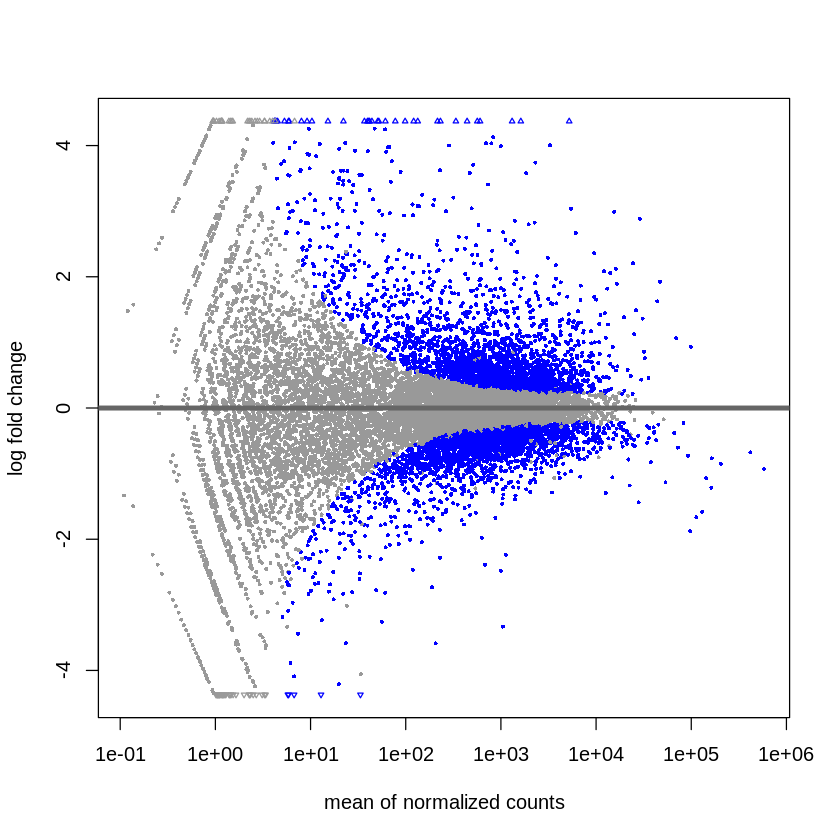

In [38]:
res0.01 <- results(dds, alpha = 0.5)
summary(res0.01)
plotMA(res_lncap)

png("MAplot_lncap.png", width = 1000, height = 900, res = 300)
plotMA(res_lncap, ylim = c(-5, 5), main = "MA Plot: LNCaP Hypoxia vs Normoxia")
dev.off()

For plot using enhanced volcano

In [39]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("EnhancedVolcano")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.21 (BiocManager 1.30.26), R 4.5.1 (2025-06-13)

Installing package(s) 'EnhancedVolcano'

Old packages: 'later', 'xml2'



Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”
Warning message:
“ggrepel: 1154 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


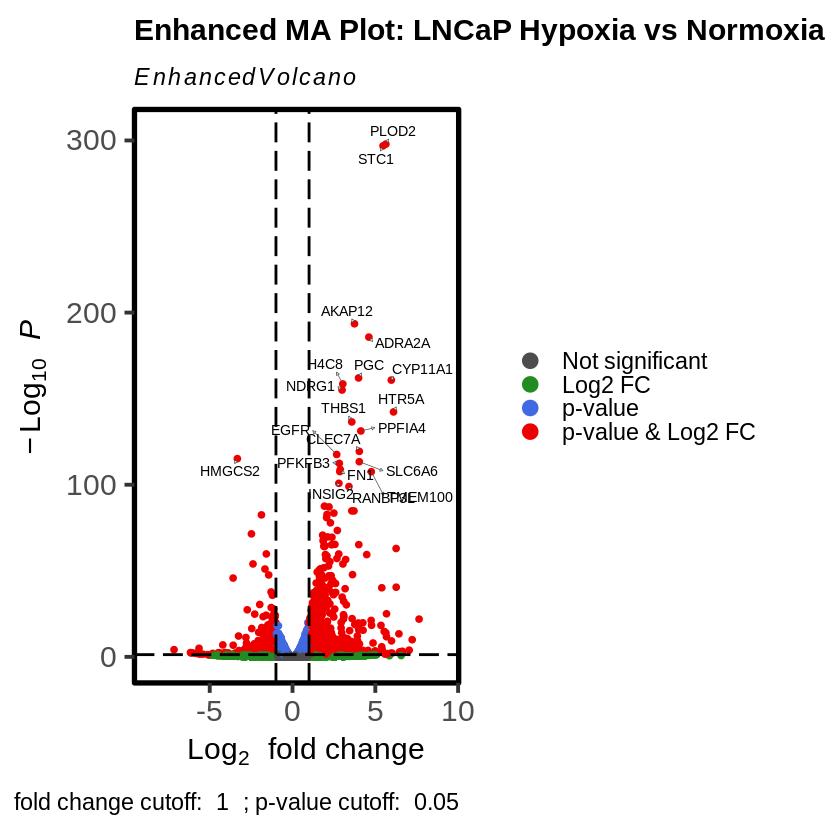

In [40]:
library(EnhancedVolcano)

res_lncap_df$Gene.name <- annotation$Gene.name[match(rownames(res_lncap_df), annotation$Gene.stable.ID)]

EnhancedVolcano(res_lncap_df,
                lab = res_lncap_df$Gene.name,
                x = 'log2FoldChange',
                y = 'pvalue',
                title = 'Enhanced MA Plot: LNCaP Hypoxia vs Normoxia',
                pCutoff = 0.05,
                FCcutoff = 1.0,
                pointSize = 1.5,
                labSize = 3.0,
                colAlpha = 1,
                legendLabels=c('Not significant','Log2 FC','p-value', 'p-value & Log2 FC'),
                legendPosition = 'right',
                legendIconSize = 4.0,
                drawConnectors = TRUE,
                widthConnectors = 0.2,
                colConnectors = 'grey30',
                cutoffLineWidth = 0.8,
                caption = bquote(~Log[2]~ 'fold change cutoff:' ~ .(1.0) ~ '; p-value cutoff:' ~ .(0.05)),
                gridlines.major = FALSE,
                gridlines.minor = FALSE,
                border = 'full',
                borderWidth = 1.5,
                borderColour = 'black'
)

For PC3 cell line

In [41]:
dds_pc3 <- dds[, grepl("PC3", colnames(dds))]
dds_pc3$condition <- droplevels(dds_pc3$condition)
dds_pc3$condition <- relevel(dds_pc3$condition, ref = "PC3_Normoxia")
dds_pc3

class: DESeqDataSet 
dim: 17551 4 
metadata(1): version
assays(4): counts mu H cooks
rownames(17551): ENSG00000000003 ENSG00000000419 ... ENSG00000310560
  ENSG00000310576
rowData names(30): baseMean baseVar ... deviance maxCooks
colnames(4): PC3_Hypoxia_S1 PC3_Hypoxia_S2 PC3_Normoxia_S1
  PC3_Normoxia_S2
colData names(2): condition sizeFactor

In [42]:
dds_pc3 <- DESeq(dds_pc3)
res_pc3 <- results(dds_pc3, contrast = c("condition", "PC3_Hypoxia", "PC3_Normoxia"))
summary(res_pc3)

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing




out of 16643 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2778, 17%
LFC < 0 (down)     : 1761, 11%
outliers [1]       : 0, 0%
low counts [2]     : 3538, 21%
(mean count < 14)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [43]:
# data frame conversion
res_pc3_df <- as.data.frame(res_pc3)

res_pc3_df <- res_pc3_df[order(res_pc3_df$padj), ]

res_pc3_df$Gene.name <- annotation$Gene.name[match(rownames(res_pc3_df), annotation$Gene.stable.ID)]
res_pc3_df$Gene.type <- annotation$Gene.type[match(rownames(res_pc3_df), annotation$Gene.stable.ID)]

head(res_pc3_df)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Gene.name,Gene.type
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ENSG00000104419,76218.672,4.525071,0.07101107,63.72345,0.000000e+00,0.000000e+00,NDRG1,protein_coding
ENSG00000146674,11618.228,4.782733,0.10539392,45.37959,0.000000e+00,0.000000e+00,IGFBP3,protein_coding
ENSG00000165507,3876.665,4.321931,0.11105831,38.91587,0.000000e+00,0.000000e+00,DEPP1,protein_coding
ENSG00000159167,5843.897,3.129052,0.09179773,34.08637,1.174198e-254,3.846968e-251,STC1,protein_coding
ENSG00000134107,8500.031,2.870339,0.08797679,32.62609,1.750009e-233,4.586773e-230,BHLHE40,protein_coding
ENSG00000176171,5667.094,2.861423,0.09053415,31.60601,3.052980e-219,6.668216e-216,BNIP3,protein_coding


In [44]:
respc3Ordered <- res_pc3_df[order(res_pc3_df$padj), ]
sum(respc3Ordered$padj < 0.05, na.rm = TRUE)
head(respc3Ordered)
summary(respc3Ordered)
write.csv(respc3Ordered, file = "DEGs_pc3.csv")

[1] 3842

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Gene.name,Gene.type
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ENSG00000104419,76218.672,4.525071,0.07101107,63.72345,0.000000e+00,0.000000e+00,NDRG1,protein_coding
ENSG00000146674,11618.228,4.782733,0.10539392,45.37959,0.000000e+00,0.000000e+00,IGFBP3,protein_coding
ENSG00000165507,3876.665,4.321931,0.11105831,38.91587,0.000000e+00,0.000000e+00,DEPP1,protein_coding
ENSG00000159167,5843.897,3.129052,0.09179773,34.08637,1.174198e-254,3.846968e-251,STC1,protein_coding
ENSG00000134107,8500.031,2.870339,0.08797679,32.62609,1.750009e-233,4.586773e-230,BHLHE40,protein_coding
ENSG00000176171,5667.094,2.861423,0.09053415,31.60601,3.052980e-219,6.668216e-216,BNIP3,protein_coding


    baseMean         log2FoldChange         lfcSE              stat         
 Min.   :     0.00   Min.   :-4.93871   Min.   :0.06998   Min.   :-14.1995  
 1st Qu.:    13.28   1st Qu.:-0.39045   1st Qu.:0.13569   1st Qu.: -1.0129  
 Median :   241.48   Median :-0.00977   Median :0.22407   Median : -0.0382  
 Mean   :  1028.86   Mean   :-0.01394   Mean   :0.73918   Mean   :  0.3934  
 3rd Qu.:   919.95   3rd Qu.: 0.32763   3rd Qu.:0.72896   3rd Qu.:  1.1700  
 Max.   :486290.44   Max.   : 6.55926   Max.   :4.96393   Max.   : 63.7234  
                     NA's   :908        NA's   :908       NA's   :908       
     pvalue             padj         Gene.name          Gene.type        
 Min.   :0.00000   Min.   :0.0000   Length:17551       Length:17551      
 1st Qu.:0.02193   1st Qu.:0.0249   Class :character   Class :character  
 Median :0.28031   Median :0.3102   Mode  :character   Mode  :character  
 Mean   :0.35440   Mean   :0.3732                                        
 3rd Qu.:0.645

Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”
Warning message:
“ggrepel: 782 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


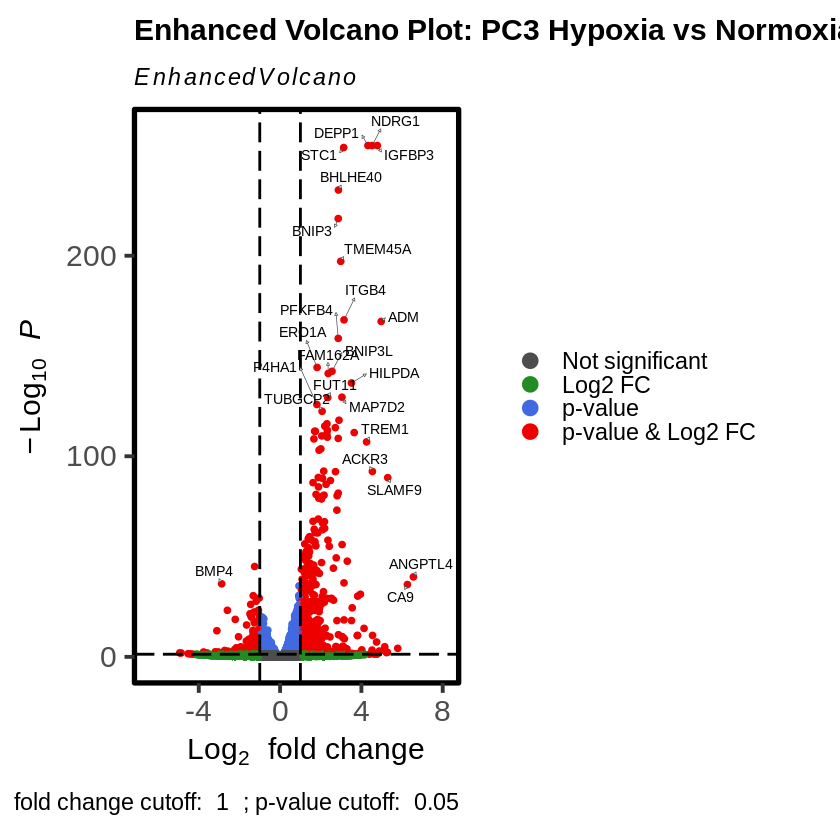

In [45]:
library(EnhancedVolcano)


res_pc3_df$Gene.name <- annotation$Gene.name[match(rownames(res_pc3_df), annotation$Gene.stable.ID)]


EnhancedVolcano(res_pc3_df,
                lab = res_pc3_df$Gene.name,
                x = 'log2FoldChange',
                y = 'pvalue',
                title = 'Enhanced Volcano Plot: PC3 Hypoxia vs Normoxia',
                pCutoff = 0.05,
                FCcutoff = 1.0,
                pointSize = 1.5,
                labSize = 3.0,
                colAlpha = 1,
                legendLabels=c('Not significant','Log2 FC','p-value', 'p-value & Log2 FC'),
                legendPosition = 'right',
                legendIconSize = 4.0,
                drawConnectors = TRUE,
                widthConnectors = 0.2,
                colConnectors = 'grey30',
                cutoffLineWidth = 0.8,
                caption = bquote(~Log[2]~ 'fold change cutoff:' ~ .(1.0) ~ '; p-value cutoff:' ~ .(0.05)),
                gridlines.major = FALSE,
                gridlines.minor = FALSE,
                border = 'full',
                borderWidth = 1.5,
                borderColour = 'black'
)

# DE subsets and further analysis

## Subset creation

Because a lot of the variability in the data is due to the difference in the background of the cell lines, we must create separate DESeq2 objects for the LNcaP and PC3 samples. The function generate_DESeq_object() below will make a DESeq2 object using your raw counts data and the two groups that you specify to compare. It will select the columns out from the raw data that match the group designations using grep(), build the colData matrix based on your group designations, and generate the DESeq2 object using DESeqDataSetFromMatrix() and DESeq().

In [46]:
generate_DESeq_object <- function (my_data, groups) {
  data_subset1 <- my_data[,grep(str_c("^", groups[1]), colnames(my_data))]
  data_subset2 <- my_data[,grep(str_c("^", groups[2]), colnames(my_data))]
  my_countData <- cbind(data_subset1, data_subset2)
  condition <- c(rep(groups[1],ncol(data_subset1)), rep(groups[2],ncol(data_subset2)))
  my_colData <- as.data.frame(condition)
  rownames(my_colData) <- colnames(my_countData)
  print(my_colData)
  dds <- DESeqDataSetFromMatrix(countData = my_countData,
                              colData = my_colData,
                              design = ~ condition)
  dds <- DESeq(dds, quiet = T)
  return(dds)
}

In [47]:
#for LNCAP
lncap <- generate_DESeq_object(raw_counts, c("LNCAP_Hypoxia", "LNCAP_Normoxia"))

                       condition
LNCAP_Hypoxia_S1   LNCAP_Hypoxia
LNCAP_Hypoxia_S2   LNCAP_Hypoxia
LNCAP_Normoxia_S1 LNCAP_Normoxia
LNCAP_Normoxia_S2 LNCAP_Normoxia


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


In [48]:
#for PC3
pc3 <- generate_DESeq_object(raw_counts, c("PC3_Hypoxia", "PC3_Normoxia"))

                   condition
PC3_Hypoxia_S1   PC3_Hypoxia
PC3_Hypoxia_S2   PC3_Hypoxia
PC3_Normoxia_S1 PC3_Normoxia
PC3_Normoxia_S2 PC3_Normoxia


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


Now that we have separated the LNCaP and PC3 samples, the variable_gene_heatmap() should display genes that are enriched in either the hypoxia vs normoxia conditions.

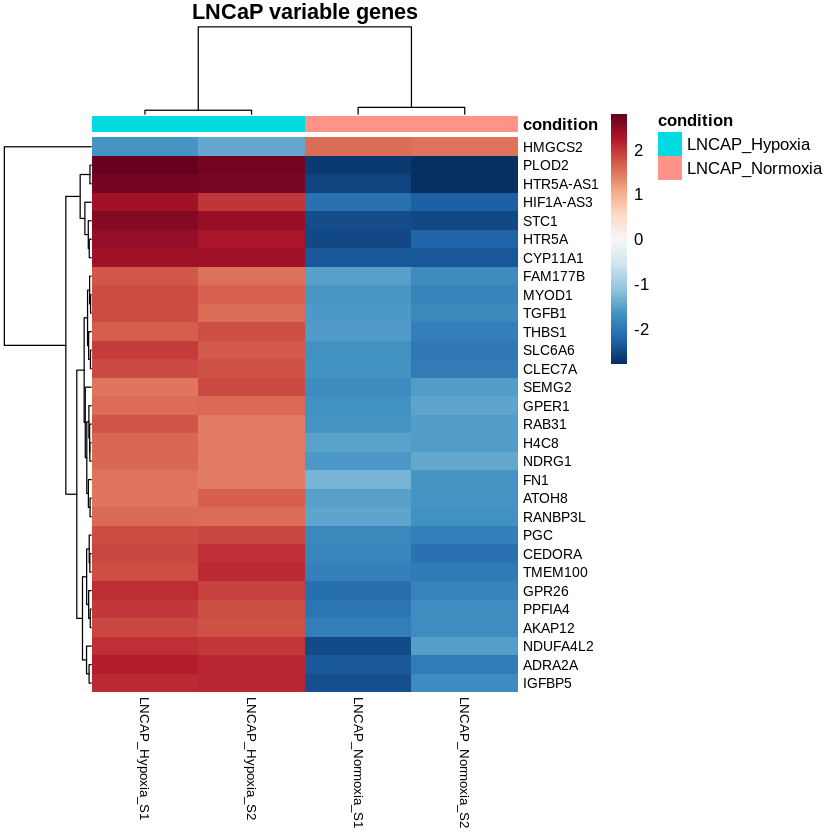

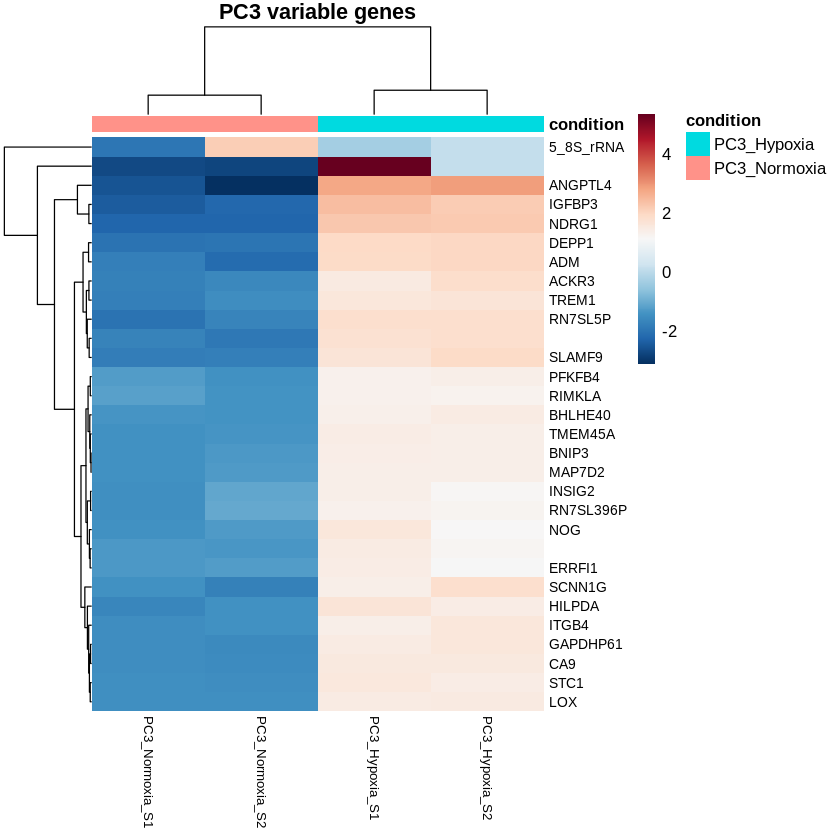

In [49]:
lncap_vsd <- vst(lncap, blind = T)
pc3_vsd <- vst(pc3, blind = T)
a <- variable_gene_heatmap(lncap_vsd, 30, annotation = annotation, title = "LNCaP variable genes")

b <- variable_gene_heatmap(pc3_vsd, 30, annotation = annotation, title = "PC3 variable genes")


## Extracting results

In [50]:
results(lncap, contrast = c("condition", "LNCAP_Hypoxia", "LNCAP_Normoxia"))

log2 fold change (MLE): condition LNCAP_Hypoxia vs LNCAP_Normoxia 
Wald test p-value: condition LNCAP_Hypoxia vs LNCAP_Normoxia 
DataFrame with 78894 rows and 6 columns
                 baseMean log2FoldChange     lfcSE      stat      pvalue
                <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSG00000000003   513.731      0.9094226  0.178087  5.106621 3.27970e-07
ENSG00000000005     0.000             NA        NA        NA          NA
ENSG00000000419  2209.827      0.0176176  0.119710  0.147169 8.82999e-01
ENSG00000000457   526.639      0.4140861  0.169688  2.440274 1.46761e-02
ENSG00000000460   336.267     -0.1170488  0.217856 -0.537276 5.91077e-01
...                   ...            ...       ...       ...         ...
ENSG00000310564   0.00000             NA        NA        NA          NA
ENSG00000310566   6.44931      -1.300372  1.303072 -0.997927    0.318315
ENSG00000310567   0.00000             NA        NA        NA          NA
ENSG00000310576  90.85697   

We observe that the hypoxia condition was compared to the normoxia condition, and that there are columns corresponding to statistics calculated for each gene.

In [53]:
library(edgeR)

generate_DE_results <- function (dds, comparisons, padjcutoff = 0.001, log2cutoff = 0.5, cpmcutoff = 2) {

  raw_counts_2 <- counts(dds, normalized = F)
  cpms <- enframe(edgeR::cpm(raw_counts_2))
  colnames(cpms) <- c("ensembl_id", "avg_cpm")


  res <- results(dds, contrast = c("condition", comparisons[1], comparisons[2]))[,-c(3,4)]

  # data annotation
  res <- as_tibble(res, rownames = "ensembl_id")
  my_annotation <- read.csv("/content/Gene_ann_GrCh38.p14.csv", header = T, stringsAsFactors = F)
  res <- left_join(res, my_annotation, by = c("ensembl_id" = "Gene.stable.ID"))
  res <- left_join(res, cpms, by = c("ensembl_id" = "ensembl_id"))

  # combining normalized counts with dds object
  normalized_counts <- round(counts(dds, normalized = TRUE),3)
  pattern <- str_c(comparisons[1], "|", comparisons[2])
  combined_data <- as_tibble(cbind(res, normalized_counts[,grep(pattern, colnames(normalized_counts))] ))
  combined_data <- combined_data[order(combined_data$log2FoldChange, decreasing = T),]

  # make ordered rank file for GSEA, selecting only protein coding genes
  res_prot <- res[which(res$Gene.type == "protein_coding"),]
  res_prot_ranked <- res_prot[order(res_prot$log2FoldChange, decreasing = T),c("Gene.name", "log2FoldChange")]
  res_prot_ranked <- na.omit(res_prot_ranked)
  res_prot_ranked$Gene.name <- str_to_upper(res_prot_ranked$Gene.name)

  # generate sorted lists with the indicated cutoff values
  res <- res[order(res$log2FoldChange, decreasing=TRUE ),]
  de_genes_padj <- res[which(res$padj < padjcutoff),]
  de_genes_log2f <- res[which(abs(res$log2FoldChange) > log2cutoff & res$padj < padjcutoff),]
  de_genes_cpm <- res[which(res$avg_cpm > cpmcutoff & res$padj < padjcutoff),]

  # Output files
  write.csv (de_genes_padj, file = paste0(comparisons[1], "_vs_", comparisons[2], "_padj_cutoff.csv"), row.names =F)
  write.csv (de_genes_log2f, file = paste0(comparisons[1], "_vs_", comparisons[2], "_log2f_cutoff.csv"), row.names =F)
  write.csv (de_genes_cpm, file = paste0(comparisons[1], "_vs_", comparisons[2], "_cpm_cutoff.csv"), row.names =F)
  write.csv (combined_data, file = paste0(comparisons[1], "_vs_", comparisons[2], "_allgenes.csv"), row.names =F)
  write.table (res_prot_ranked, file = paste0(comparisons[1], "_vs_", comparisons[2], "_rank.rnk"), sep = "\t", row.names = F, quote = F)

  writeLines( paste0("For the comparison: ", comparisons[1], "_vs_", comparisons[2], ", out of ", nrow(combined_data), " genes, there were: \n",
               nrow(de_genes_padj), " genes below padj ", padjcutoff, "\n",
               nrow(de_genes_log2f), " genes below padj ", padjcutoff, " and above a log2FoldChange of ", log2cutoff, "\n",
               nrow(de_genes_cpm), " genes below padj ", padjcutoff, " and above an avg cpm of ", cpmcutoff, "\n",
               "Gene lists ordered by log2fchange with the cutoffs above have been generated.") )
  gene_count <- tibble (cutoff_parameter = c("padj", "log2fc", "avg_cpm" ),
                        cutoff_value = c(padjcutoff, log2cutoff, cpmcutoff),
                        signif_genes = c(nrow(de_genes_padj), nrow(de_genes_log2f), nrow(de_genes_cpm)))
  invisible(gene_count)
}

# Example call to the function
generate_DE_results(lncap, c("LNCAP_Hypoxia", "LNCAP_Normoxia"))

Loading required package: limma


Attaching package: ‘limma’


The following object is masked from ‘package:DESeq2’:

    plotMA


The following object is masked from ‘package:BiocGenerics’:

    plotMA




For the comparison: LNCAP_Hypoxia_vs_LNCAP_Normoxia, out of 78894 genes, there were: 
2834 genes below padj 0.001
2610 genes below padj 0.001 and above a log2FoldChange of 0.5
10409 genes below padj 0.001 and above an avg cpm of 2
Gene lists ordered by log2fchange with the cutoffs above have been generated.


In [54]:
# For lncap
lncap_output <- generate_DE_results (lncap, c("LNCAP_Hypoxia", "LNCAP_Normoxia"))

For the comparison: LNCAP_Hypoxia_vs_LNCAP_Normoxia, out of 78894 genes, there were: 
2834 genes below padj 0.001
2610 genes below padj 0.001 and above a log2FoldChange of 0.5
10409 genes below padj 0.001 and above an avg cpm of 2
Gene lists ordered by log2fchange with the cutoffs above have been generated.


In [55]:
# For pc3
pc3_output <- generate_DE_results(pc3, c("PC3_Hypoxia", "PC3_Normoxia"))

For the comparison: PC3_Hypoxia_vs_PC3_Normoxia, out of 78894 genes, there were: 
1498 genes below padj 0.001
1308 genes below padj 0.001 and above a log2FoldChange of 0.5
5712 genes below padj 0.001 and above an avg cpm of 2
Gene lists ordered by log2fchange with the cutoffs above have been generated.


The output csv files will be generated and stored.

In [56]:
res <- read.csv("LNCAP_Hypoxia_vs_LNCAP_Normoxia_allgenes.csv", header = T)
head(res)

,ensembl_id,baseMean,log2FoldChange,pvalue,padj,Gene.name,Gene.type,avg_cpm.LNCAP_Hypoxia_S1,avg_cpm.LNCAP_Hypoxia_S2,avg_cpm.LNCAP_Normoxia_S1,avg_cpm.LNCAP_Normoxia_S2,LNCAP_Hypoxia_S1,LNCAP_Hypoxia_S2,LNCAP_Normoxia_S1,LNCAP_Normoxia_S2
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000283339,38.94889,8.795450,8.672600e-09,1.569664e-07,,unprocessed_pseudogene,1.8765320,2.0678950,0.00000000,0.00000000,74.447,81.348,0.000,0.000
2,ENSG00000261051,21.13735,7.913766,6.984912e-07,9.081717e-06,,lncRNA,1.0082860,1.1324190,0.00000000,0.00000000,40.001,44.548,0.000,0.000
3,ENSG00000105329,199.34450,7.702373,5.352192e-24,4.099739e-22,TGFB1,protein_coding,11.0631300,9.0101130,0.07843531,0.02154691,438.905,354.447,3.165,0.862
4,ENSG00000224658,16.31556,7.541847,4.406242e-06,4.763027e-05,,lncRNA,0.6441825,1.0093300,0.00000000,0.00000000,25.556,39.706,0.000,0.000
5,ENSG00000290684,15.21971,7.437271,6.989741e-06,7.214430e-05,OR2W5P,lncRNA,0.9242619,0.6154449,0.00000000,0.00000000,36.668,24.211,0.000,0.000
6,ENSG00000255671,14.03720,7.321953,1.109978e-05,1.089835e-04,,lncRNA,0.7562143,0.6646805,0.00000000,0.00000000,30.001,26.148,0.000,0.000


# Differential gene heatmap

## For LNCAP Normoxia vs Hypoxia

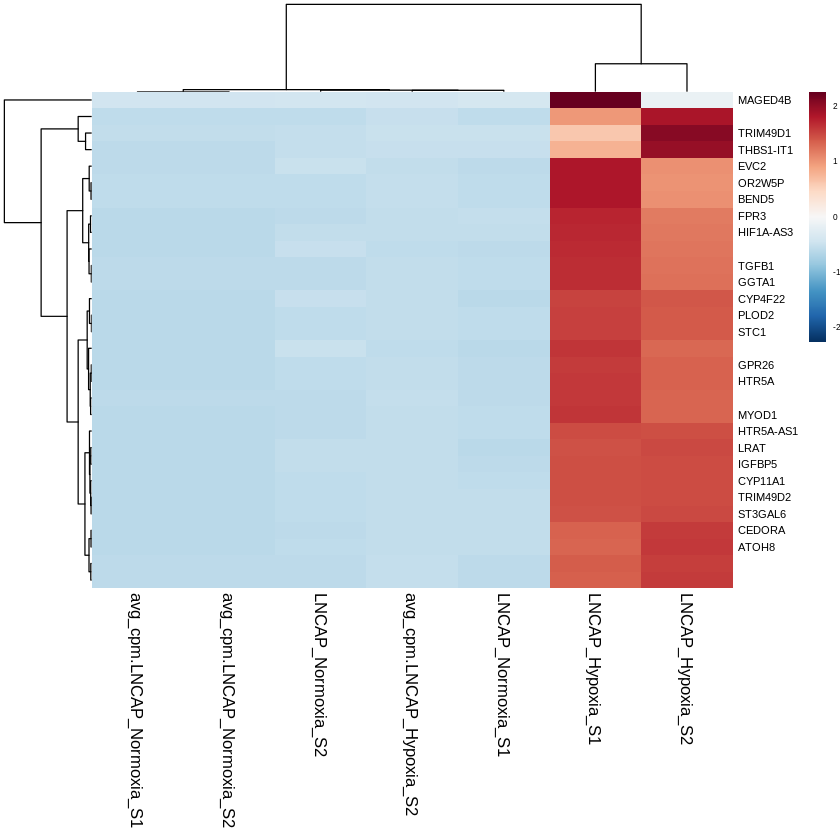

In [57]:
#Using all genes file
res <- read.csv ("LNCAP_Hypoxia_vs_LNCAP_Normoxia_allgenes.csv", header = T)

DE_gene_heatmap <- function(res, padj_cutoff = 0.0001, ngenes = 20) {
  brewer_palette <- "RdBu"
  ramp <- colorRampPalette(RColorBrewer::brewer.pal(11, brewer_palette))
  mr <- ramp(256)[256:1]
  significant_genes <- res %>% filter(padj < padj_cutoff) %>% arrange (desc(log2FoldChange)) %>% head (ngenes)
  heatmap_values <- as.matrix(significant_genes[,-c(1:8)])
  rownames(heatmap_values) <- significant_genes$Gene.name
  pheatmap::pheatmap(heatmap_values, color = mr, scale = "row", fontsize_col = 10, fontsize_row = 200/ngenes, fontsize = 5, border_color = NA)
}
DE_gene_heatmap(res, 0.001, 30)

## For PC3 Normoxia vs Hypoxia

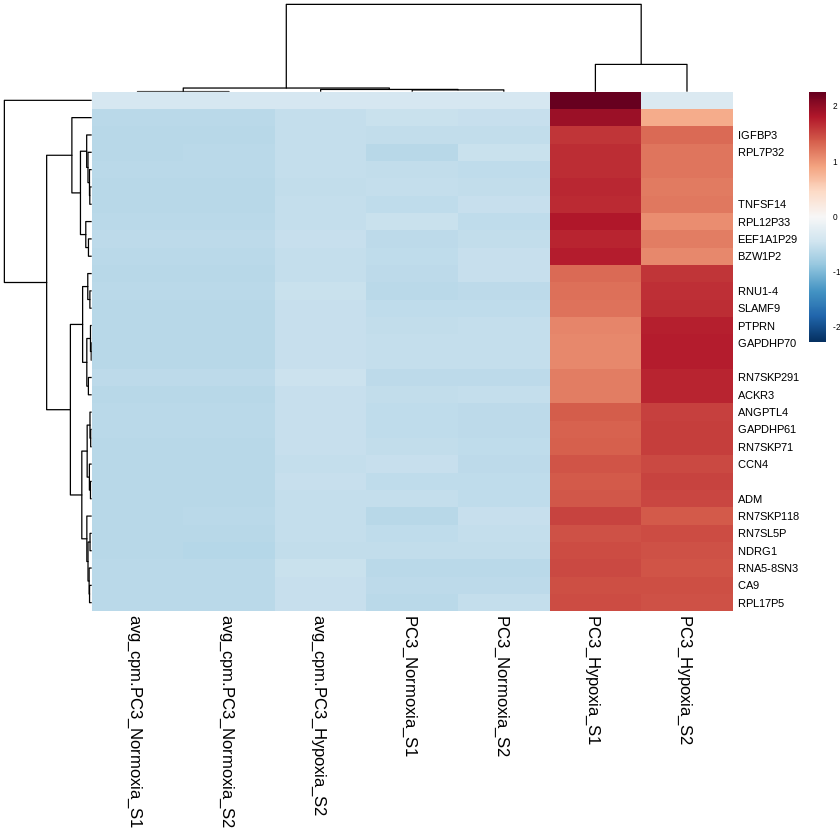

In [58]:
#Using all genes file
res <- read.csv ("/content/PC3_Hypoxia_vs_PC3_Normoxia_allgenes.csv", header = T)

DE_gene_heatmap <- function(res, padj_cutoff = 0.0001, ngenes = 20) {
  brewer_palette <- "RdBu"
  ramp <- colorRampPalette(RColorBrewer::brewer.pal(11, brewer_palette))
  mr <- ramp(256)[256:1]
  significant_genes <- res %>% filter(padj < padj_cutoff) %>% arrange (desc(log2FoldChange)) %>% head (ngenes)
  heatmap_values <- as.matrix(significant_genes[,-c(1:8)])
  rownames(heatmap_values) <- significant_genes$Gene.name
  pheatmap::pheatmap(heatmap_values, color = mr, scale = "row", fontsize_col = 10, fontsize_row = 200/ngenes, fontsize = 5, border_color = NA)
}
DE_gene_heatmap(res, 0.001, 30)

# Volcano Plot

## For LNCAP

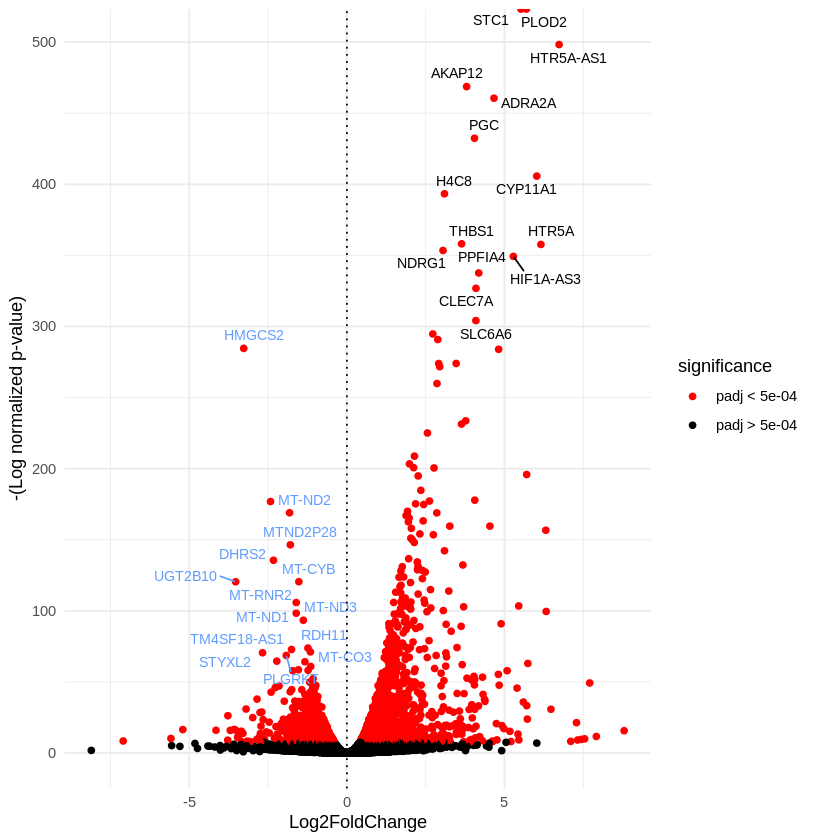

In [59]:
res <- read.csv ("LNCAP_Hypoxia_vs_LNCAP_Normoxia_allgenes.csv", header = T)

plot_volcano <- function (res, padj_cutoff, nlabel = 10, label.by = "padj"){
  # using padj values for significant results
  res <- mutate(res, significance=ifelse(res$padj<padj_cutoff, paste0("padj < ", padj_cutoff), paste0("padj > ", padj_cutoff)))
  res = res[!is.na(res$significance),]
  significant_genes <- res %>% filter(significance == paste0("padj < ", padj_cutoff))

  # getting labels for the highest or lowest genes according to either padj or log2FoldChange
  if (label.by == "padj") {
    top_genes <- significant_genes %>% arrange(padj) %>% head(nlabel)
    bottom_genes <- significant_genes %>% filter (log2FoldChange < 0) %>% arrange(padj) %>% head (nlabel)
  } else if (label.by == "log2FoldChange") {
    top_genes <- head(arrange(significant_genes, desc(log2FoldChange)),nlabel)
    bottom_genes <- head(arrange(significant_genes, log2FoldChange),nlabel)
  } else
    stop ("Invalid label.by argument. Choose either padj or log2FoldChange.")

  ggplot(res, aes(log2FoldChange, -log(padj))) +
    geom_point(aes(col=significance)) +
    scale_color_manual(values=c("red", "black")) +
    ggrepel::geom_text_repel(data=top_genes, aes(label=head(Gene.name,nlabel)), size = 3)+
    ggrepel::geom_text_repel(data=bottom_genes, aes(label=head(Gene.name,nlabel)), color = "#619CFF", size = 3)+
    labs ( x = "Log2FoldChange", y = "-(Log normalized p-value)")+
    geom_vline(xintercept = 0, linetype = "dotted")+
    theme_minimal()
}

plot_volcano(res, 0.0005, nlabel = 15, label.by = "padj")

## For PC3

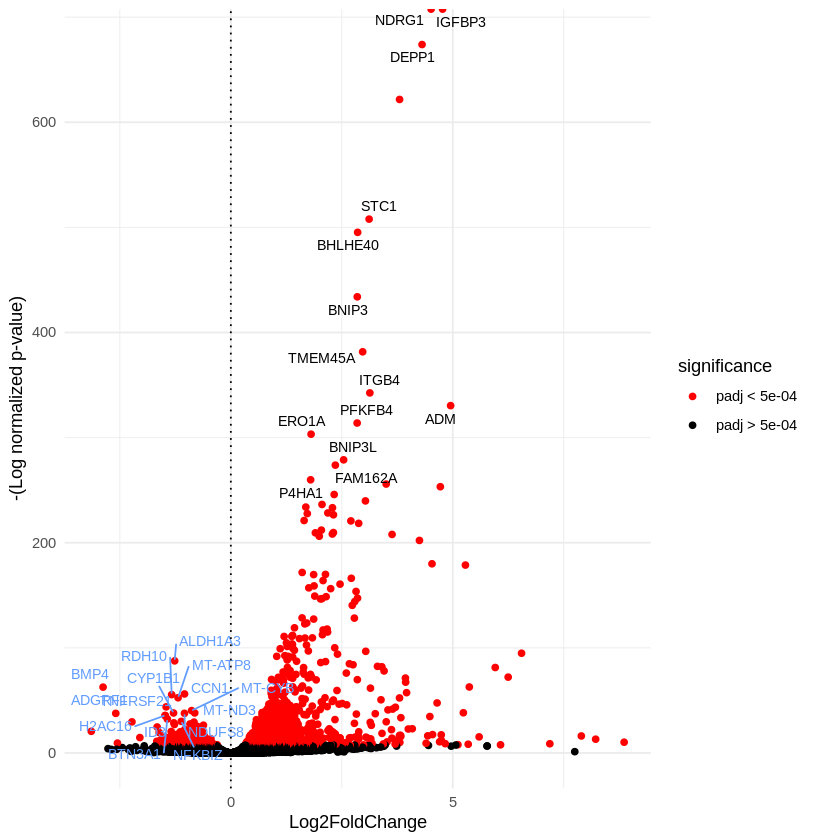

In [60]:
res <- read.csv ("/content/PC3_Hypoxia_vs_PC3_Normoxia_allgenes.csv", header = T)

plot_volcano <- function (res, padj_cutoff, nlabel = 10, label.by = "padj"){
  # using padj values for significant results
  res <- mutate(res, significance=ifelse(res$padj<padj_cutoff, paste0("padj < ", padj_cutoff), paste0("padj > ", padj_cutoff)))
  res = res[!is.na(res$significance),]
  significant_genes <- res %>% filter(significance == paste0("padj < ", padj_cutoff))

  # get labels for the highest or lowest genes according to either padj or log2FoldChange
  if (label.by == "padj") {
    top_genes <- significant_genes %>% arrange(padj) %>% head(nlabel)
    bottom_genes <- significant_genes %>% filter (log2FoldChange < 0) %>% arrange(padj) %>% head (nlabel)
  } else if (label.by == "log2FoldChange") {
    top_genes <- head(arrange(significant_genes, desc(log2FoldChange)),nlabel)
    bottom_genes <- head(arrange(significant_genes, log2FoldChange),nlabel)
  } else
    stop ("Invalid label.by argument. Choose either padj or log2FoldChange.")

  ggplot(res, aes(log2FoldChange, -log(padj))) +
    geom_point(aes(col=significance)) +
    scale_color_manual(values=c("red", "black")) +
    ggrepel::geom_text_repel(data=top_genes, aes(label=head(Gene.name,nlabel)), size = 3, max.overlaps = 25)+
    ggrepel::geom_text_repel(data=bottom_genes, aes(label=head(Gene.name,nlabel)), color = "#619CFF", size = 3, max.overlaps = 25)+
    labs ( x = "Log2FoldChange", y = "-(Log normalized p-value)")+
    geom_vline(xintercept = 0, linetype = "dotted")+
    theme_minimal()
}

plot_volcano(res, 0.0005, nlabel = 15, label.by = "padj")

# Log fold change comparison plot

we can take the significant genes from the hypoxia vs normoxia comparison for both lines and generate a scatterplot of their log2FoldChange values using the custom function below, compare_significant_genes(). This function will display the overlap in the gene lists by color coding significant genes that are shared by both cell lines, as well as those that are unique to each individual cell line.

This is to answer:
*   Are the genes that are induced by hypoxia similar in both cell lines?
*   Which significant genes are shared by both cell lines and which genes are unique to each cell line?





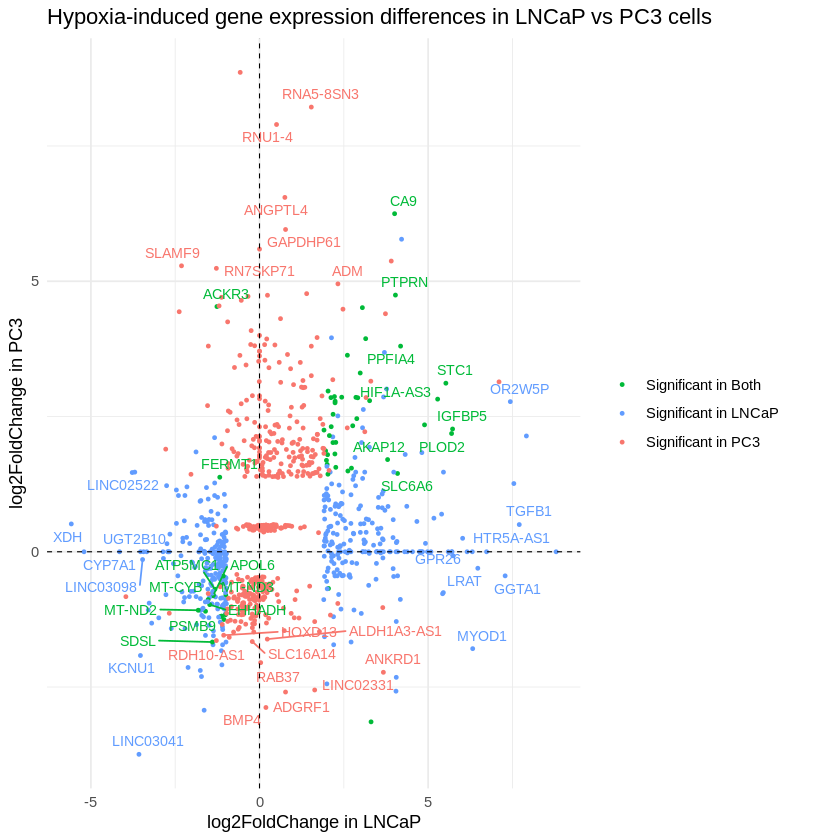

In [77]:
res1 <- read.csv ("LNCAP_Hypoxia_vs_LNCAP_Normoxia_allgenes.csv", header = T)
res2 <- read.csv ("PC3_Hypoxia_vs_PC3_Normoxia_allgenes.csv", header = T)

compare_significant_genes <- function (res1, res2, padj_cutoff=0.0001, ngenes=250, nlabel=10, samplenames=c("comparison1", "comparison2"), title = "" ) {
  # list of most upregulated or downregulated genes for each results table
  genes1 <- rbind(head(res1[which(res1$padj < padj_cutoff),], ngenes), tail(res1[which(res1$padj < padj_cutoff),], ngenes))
  genes2 <- rbind(head(res2[which(res2$padj < padj_cutoff),], ngenes), tail(res2[which(res2$padj < padj_cutoff),], ngenes))

   # combine the data from both tables
  de_union <- union(genes1$ensembl_id,genes2$ensembl_id)
  res1_union <- res1[match(de_union, res1$ensembl_id),][c("ensembl_id", "log2FoldChange", "Gene.name")]
  res2_union <- res2[match(de_union, res2$ensembl_id),][c("ensembl_id", "log2FoldChange", "Gene.name")]
  combined <- left_join(res1_union, res2_union, by = "ensembl_id", suffix = samplenames )

  # identify overlap between genes in both tables
  combined$de_condition <- 1 # makes a placeholder column
  combined$de_condition[which(combined$ensembl_id %in% intersect(genes1$ensembl_id,genes2$ensembl_id))] <- "Significant in Both"
  combined$de_condition[which(combined$ensembl_id %in% setdiff(genes1$ensembl_id,genes2$ensembl_id))] <- paste0("Significant in ", samplenames[1])
  combined$de_condition[which(combined$ensembl_id %in% setdiff(genes2$ensembl_id,genes1$ensembl_id))] <- paste0("Significant in ", samplenames[2])
  combined[is.na(combined)] <- 0

  # find the top most genes within each condition to label on the graph
  label1 <- rbind(head(combined[which(combined$de_condition==paste0("Significant in ", samplenames[1])),],nlabel),
                  tail(combined[which(combined$de_condition==paste0("Significant in ", samplenames[1])),],nlabel))
  label2 <- rbind(head(combined[which(combined$de_condition==paste0("Significant in ", samplenames[2])),],nlabel),
                  tail(combined[which(combined$de_condition==paste0("Significant in ", samplenames[2])),],nlabel))
  label3 <- rbind(head(combined[which(combined$de_condition=="Significant in Both"),],nlabel),
                  tail(combined[which(combined$de_condition=="Significant in Both"),],nlabel))
  combined_labels <- rbind(label1,label2,label3)

  # plot the genes based on log2FoldChange, color coded by significance
  ggplot(combined, aes_string(x = paste0("log2FoldChange", samplenames[1]), y = paste0("log2FoldChange", samplenames[2]) )) +
      geom_point(aes(color = de_condition), size = 0.7)+
      scale_color_manual(values= c("#00BA38", "#619CFF", "#F8766D"))+
      ggrepel::geom_text_repel(data= combined_labels, aes_string(label=paste0("Gene.name", samplenames[1]), color = "de_condition"), show.legend = F, size=3, max.overlaps = 50)+ # Increased max.overlaps
      geom_vline(xintercept = c(0,0), size = 0.3, linetype = 2)+
      geom_hline(yintercept = c(0,0), size = 0.3, linetype = 2)+
      labs(title = title,x = paste0("log2FoldChange in ", samplenames[1]), y = paste0("log2FoldChange in ", samplenames[2]))+
      theme_minimal()+
      theme(legend.title = element_blank())
}

compare_significant_genes(res1,res2, samplenames = c("LNCaP", "PC3"), title = "Hypoxia-induced gene expression differences in LNCaP vs PC3 cells")

We observe that there are indeed a small subset of genes that are differentially expressed in both the LNCaP as well as PC3 comparisons (green labels)

# Gene Set Enrichment analysis

Gene Set Enrichment Analysis (GSEA) can be used to test whether pathways consisting of multiple genes are enriched in one group compared to another.

## Top 20 enriched pathway

### For PC3

In [131]:
# PC3
res_pc3 <- read.csv("/content/DEGs_pc3.csv", row.names =1)
head(res_lncap)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,ENSEMBL
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000152952,5219.1198,5.636692,0.1212029,46.50625,0.000000e+00,0.000000e+00,ENSG00000152952
ENSG00000159167,1619.0183,5.468060,0.1482968,36.87241,1.279480e-297,8.852723e-294,ENSG00000159167
ENSG00000131016,2300.7694,3.741240,0.1258387,29.73045,3.103368e-194,1.431480e-190,ENSG00000131016
ENSG00000150594,1311.3579,4.611206,0.1583245,29.12502,1.731309e-186,5.989463e-183,ENSG00000150594
ENSG00000096088,996.6574,3.990103,0.1467648,27.18706,9.238910e-163,2.556961e-159,ENSG00000096088
ENSG00000140459,604.0121,5.966190,0.2203114,27.08072,1.661176e-161,3.831227e-158,ENSG00000140459


In [135]:
# for PC3
res_pc3$ENSEMBL <- rownames(res_pc3)

res_mapped <- res_pc3 %>%
  left_join(ncbi_list, by = "ENSEMBL") %>%
  filter(!is.na(ENTREZID)) %>%
  distinct(ENTREZID, .keep_all = TRUE)

ngenes <- res_mapped$log2FoldChange
names(ngenes) <- res_mapped$ENTREZID
ngenes <- sort(ngenes, decreasing = TRUE)

# checking the entry
print(paste("Number of genes for GSEA:", length(ngenes)))
print("Head of ngenes (named vector):")
print(head(ngenes))


library(ReactomePA)
enp_gsea <- gsePathway(
  ngenes,
  organism = "human",
  #pvalueCutoff = 0.05,
  verbose = FALSE
)

head(enp_gsea@result)

[1] "Number of genes for GSEA: 16464"
[1] "Head of ngenes (named vector):"
   51129      768   728689    89886   728597     7080 
6.559255 6.263414 5.787248 5.296754 5.275843 5.252821 


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (11.81% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
R-HSA-70171,R-HSA-70171,Glycolysis,68,0.6089187,2.051473,2.946872e-06,0.003533275,0.003312993,2582,"tags=34%, list=16%, signal=29%",5210/230/5209/2026/5230/229/80201/2821/3101/5214/3099/7167/3098/5211/2023/5223/226/5313/283209/5315/2597/23225/9818
R-HSA-1912408,R-HSA-1912408,Pre-NOTCH Transcription and Translation,86,0.5596654,1.983404,5.452362e-06,0.003533275,0.003312993,1865,"tags=20%, list=11%, signal=18%",723790/554313/333932/126961/8370/8363/8354/1999/4854/861/1991/3725/8346/3516/8347/8356/8349
R-HSA-1912422,R-HSA-1912422,Pre-NOTCH Expression and Processing,102,0.5336520,1.949670,6.654002e-06,0.003533275,0.003312993,1950,"tags=20%, list=12%, signal=17%",723790/554313/333932/126961/8370/8363/8354/1999/4854/861/1991/4242/3725/8346/3516/488/8347/8356/8349/10402
R-HSA-3214842,R-HSA-3214842,HDMs demethylate histones,45,0.6494648,2.003544,2.237226e-05,0.006848214,0.006421261,2099,"tags=31%, list=13%, signal=27%",554313/333932/126961/8370/8363/8354/55818/23030/23081/23210/84678/8356/10765/22992
R-HSA-5334118,R-HSA-5334118,DNA methylation,56,0.5940400,1.936264,6.815028e-05,0.006848214,0.006421261,361,"tags=12%, list=2%, signal=12%",723790/554313/333932/126961/8370/8363/8354
R-HSA-3214858,R-HSA-3214858,RMTs methylate histone arginines,71,0.5667861,1.936113,5.386199e-05,0.006848214,0.006421261,423,"tags=11%, list=3%, signal=11%",723790/554313/333932/126961/8370/8363/8354/8336


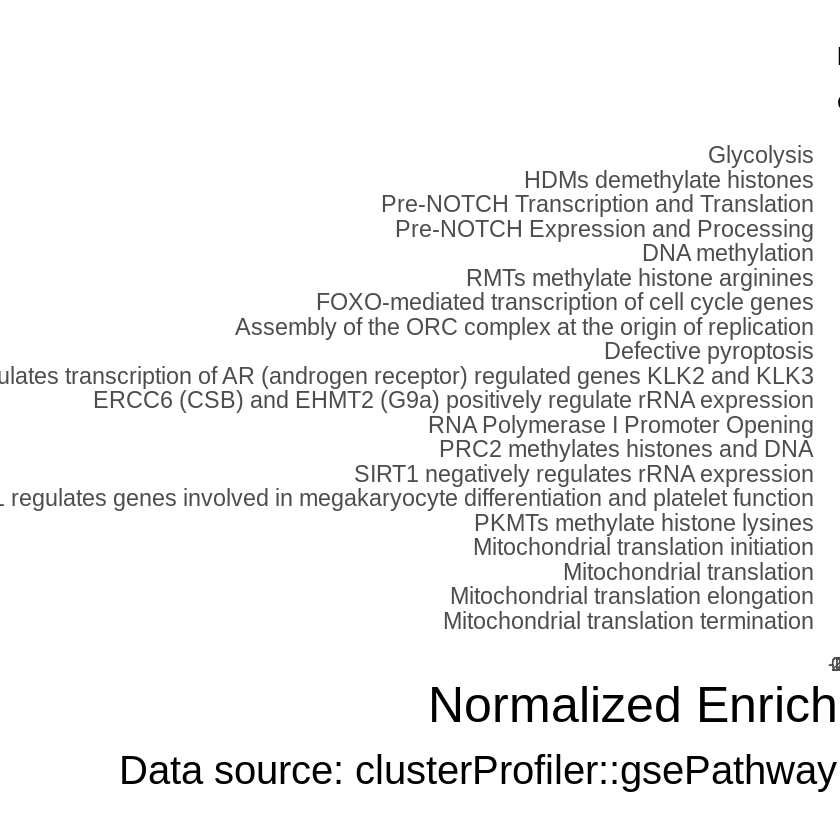

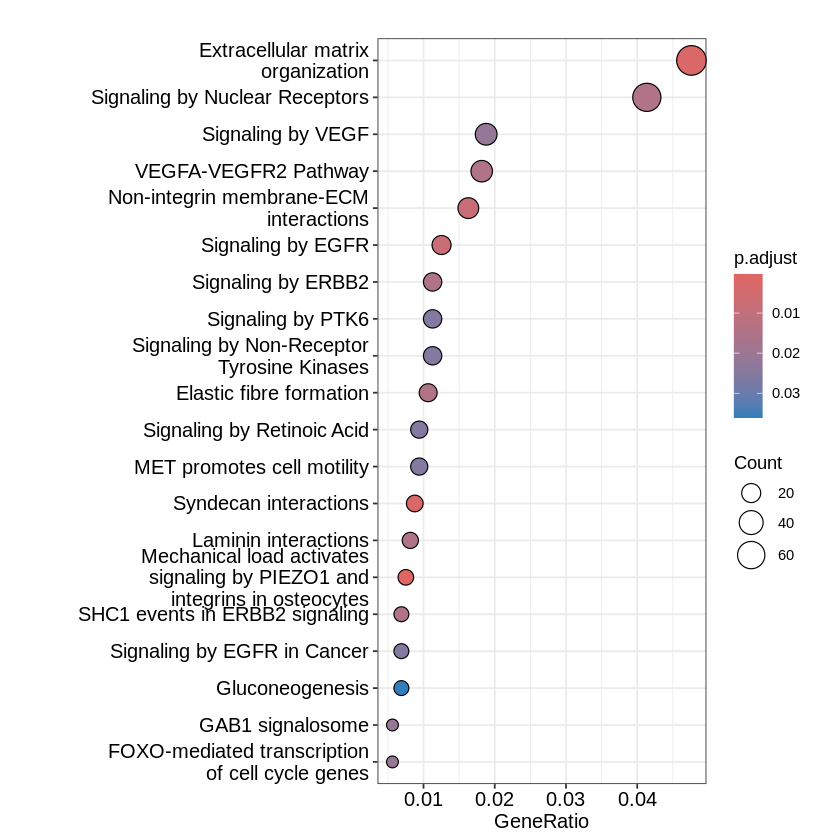

In [138]:
# for PC3

pathways <- enp_gsea@result
pathways <- pathways[order(pathways$p.adjust), ]  # Sort by FDR (adjusted p-value)
top_pathways <- pathways[order(abs(pathways$NES), decreasing = TRUE), ]  # Sort by NES

library(dplyr)
library(forcats)

top20 <- top_pathways[1:20, ] %>%
  mutate(Description = fct_reorder(Description, NES))  # Reorder factor for y-axis

library(ggplot2)

r2 <- ggplot(top20, aes(x = NES,
                        y = Description,
                        color = p.adjust,
                        size = setSize)) +
  geom_point(alpha = 0.9) +
  scale_color_gradient(low = "#0072B2", high = "#D55E00", name = "FDR (p.adjust)") +
  scale_size(range = c(3, 10), name = "Gene Set Size") +
  labs(
    title = "Reflect Top 20 Enriched Pathways PC3",
    subtitle = "Gene Set Enrichment Analysis (GSEA)",
    x = "Normalized Enrichment Score (NES)",
    y = NULL,
    caption = "Data source: clusterProfiler::gsePathway"
  ) +
  theme_minimal(base_size = 30) +
  theme(
    axis.text.y = element_text(size = 14),
    axis.text.x = element_text(size = 12),
    plot.title = element_text(face = "bold", size = 16),
    plot.subtitle = element_text(size = 13),
    legend.position = "right",
    plot.margin = unit(c(1, 1, 1, 1), "cm")
  )

print(r2)

ggsave("top_pathways_gsea_plot_PC3.png", plot = r1, width = 12, height = 10, dpi = 300)
ggsave("top_pathways_gsea_plot_PC3.pdf", plot = r1, width = 12, height = 10)

library(ReactomePA)
sig_genes <- res_mapped %>%
  filter(padj < 0.1, abs(log2FoldChange) > 0.5) %>%
  pull(ENTREZID)
enr <- enrichPathway(gene = sig_genes, organism = "human", pvalueCutoff = 0.1)
dotplot(enr, showCategory=20)

strong enrichment in extracellular matrix organization and receptor tyrosine kinase signaling pathways (VEGF, EGFR, ERBB2, MET). These changes suggest undergoing cell adhesion changes, angiogenesis, and possibly cancer-like invasive and motility processes.

### LNCAP

In [62]:
res_lncap <- read.csv("DEGs_lncap.csv", row.names = 1)
head(res_lncap)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000152952,5219.1198,5.636692,0.1212029,46.50625,0.000000e+00,0.000000e+00
ENSG00000159167,1619.0183,5.468060,0.1482968,36.87241,1.279480e-297,8.852723e-294
ENSG00000131016,2300.7694,3.741240,0.1258387,29.73045,3.103368e-194,1.431480e-190
ENSG00000150594,1311.3579,4.611206,0.1583245,29.12502,1.731309e-186,5.989463e-183
ENSG00000096088,996.6574,3.990103,0.1467648,27.18706,9.238910e-163,2.556961e-159
ENSG00000140459,604.0121,5.966190,0.2203114,27.08072,1.661176e-161,3.831227e-158


In [132]:
library(clusterProfiler)
library(org.Hs.eg.db)
library(AnnotationDbi)

ncbi_list <- mapIds(
  x = org.Hs.eg.db,
  keys = rownames(res_lncap),
  column = "ENTREZID",
  keytype = "ENSEMBL",
  multiVals = "first"
)
# Convert the result to a data frame for consistency with the previous bitr output structure
ncbi_list <- data.frame(
  ENSEMBL = names(ncbi_list),
  ENTREZID = ncbi_list
)

# omiting the values which are not available
ncbi_list <- na.omit(ncbi_list)

head(ncbi_list) #for PC3

'select()' returned 1:many mapping between keys and columns



,ENSEMBL,ENTREZID
,<chr>,<chr>
ENSG00000152952,ENSG00000152952,5352
ENSG00000159167,ENSG00000159167,6781
ENSG00000131016,ENSG00000131016,9590
ENSG00000150594,ENSG00000150594,150
ENSG00000096088,ENSG00000096088,5225
ENSG00000140459,ENSG00000140459,1583


In [63]:
library(clusterProfiler)
library(org.Hs.eg.db)
library(AnnotationDbi)


ncbi_list <- mapIds(
  x = org.Hs.eg.db,
  keys = rownames(res_lncap),
  column = "ENTREZID",
  keytype = "ENSEMBL",
  multiVals = "first"
)

# Convert the result to a data frame for consistency with the previous bitr output structure
ncbi_list <- data.frame(
  ENSEMBL = names(ncbi_list),
  ENTREZID = ncbi_list
)

# omiting the values which are not available
ncbi_list <- na.omit(ncbi_list)

head(ncbi_list)

'select()' returned 1:many mapping between keys and columns



,ENSEMBL,ENTREZID
,<chr>,<chr>
ENSG00000152952,ENSG00000152952,5352
ENSG00000159167,ENSG00000159167,6781
ENSG00000131016,ENSG00000131016,9590
ENSG00000150594,ENSG00000150594,150
ENSG00000096088,ENSG00000096088,5225
ENSG00000140459,ENSG00000140459,1583


In [134]:
res_lncap$ENSEMBL <- rownames(res_lncap)

In [65]:
res_mapped <- res_lncap %>%
  left_join(ncbi_list, by = "ENSEMBL") %>%
  filter(!is.na(ENTREZID)) %>%
  distinct(ENTREZID, .keep_all = TRUE)

ngenes <- res_mapped$log2FoldChange
names(ngenes) <- res_mapped$ENTREZID
ngenes <- sort(ngenes, decreasing = TRUE)

# checking the entry
print(paste("Number of genes for GSEA:", length(ngenes)))
print("Head of ngenes (named vector):")
print(head(ngenes))


library(ReactomePA)
enp_gsea <- gsePathway(
  ngenes,
  organism = "human",
  #pvalueCutoff = 0.05,
  verbose = FALSE
)

head(enp_gsea@result)

[1] "Number of genes for GSEA: 16962"
[1] "Head of ngenes (named vector):"
    7040     2681    79656    59350   163933    28638 
7.642905 7.226637 7.044386 6.640752 6.574441 6.558269 


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (9.27% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some of the pathways the P-values were likely overestimated. For such pathways log2err is set to NA.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”


,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
R-HSA-8868773,R-HSA-8868773,rRNA processing in the nucleus and cytosol,192,-0.5459433,-2.114530,1.000000e-10,6.032652e-08,5.597753e-08,5926,"tags=70%, list=35%, signal=46%",56915/6136/55813/6191/81875/6166/5822/51010/134430/23160/5393/51121/6154/9277/56902/55127/6230/51013/55781/54512/6139/28987/10171/6168/79707/65083/6205/6144/23481/81887/4691/9045/6167/79159/6228/6224/6125/6229/10969/6164/27341/6165/51118/6175/6207/6189/6135/6122/11340/55505/88745/6202/9349/23404/10556/6192/6158/6231/6206/6169/6188/23521/114049/6209/6187/3921/118460/6233/11224/54555/6171/51077/27340/7311/6210/10436/22984/6227/6201/10528/6157/10885/6159/6234/6152/6134/6194/6204/6128/57418/55651/6156/6130/6132/6161/4809/6143/6222/6141/51602/25879/6217/6129/2197/200916/25873/25926/6232/115939/6208/6155/6133/51504/6147/6160/6181/6142/10813/6193/6137/6176/27292/4736/9136/6124/54433/116832/6203/6235/6170/140032/10799/6223/6123
R-HSA-72766,R-HSA-72766,Translation,290,-0.5141345,-2.083797,1.000000e-10,6.032652e-08,5.597753e-08,6240,"tags=73%, list=37%, signal=47%",6734/6146/90701/28972/64979/2193/51253/51021/740/63875/54938/1915/51263/6136/9553/51067/6191/3735/6166/90480/92259/29093/10952/8666/54534/10056/23708/56945/64983/26284/1974/7453/9255/51121/65005/6154/1978/51373/6230/3646/60559/10480/64963/6139/51386/5917/8894/6168/92935/6205/10573/6144/4141/3396/1975/5018/8664/9045/63931/6167/8667/124995/6228/6224/54460/6125/6229/51069/6164/1938/6165/28998/80222/16/5464/1650/6175/6207/54998/64969/6189/4677/6135/57129/51023/51116/6122/118487/6202/10884/9789/27335/51642/9349/833/8669/58477/219927/64965/51264/6192/6158/51081/10240/6231/6206/6169/6188/23521/6209/6187/3921/7818/6233/11224/6746/6171/7311/2058/6210/6227/6201/51258/6157/51649/2617/6159/6234/64960/6152/28973/1964/11222/6134/55052/6194/6204/84340/6128/64975/1936/64432/23395/51073/1933/54948/6156/6130/6301/123263/6132/60488/6161/65003/1917/122704/6143/10352/6222/29074/6141/7965/1968/6217/6129/124454/2197/200916/25873/23107/6232/6208/51520/4528/6155/6133/6747/64976/6183/51504/51318/6147/6160/6181/6142/6193/6137/79587/78988/3376/6176/65008/51650/4736/6124/29088/8891/27068/116832/6203/6235/6170/140032/6150/8565/55157/116541/10667/6182/79590/6223/6123
R-HSA-72312,R-HSA-72312,rRNA processing,202,-0.5321924,-2.072309,1.122702e-10,6.032652e-08,5.597753e-08,5435,"tags=69%, list=32%, signal=47%",56915/6136/55813/6191/81875/6166/5822/51010/134430/23160/5393/51121/6154/9277/56902/55127/6230/54931/51013/55781/54512/6139/28987/10171/6168/79707/65083/6205/6144/23481/60528/81887/4691/9045/6167/79159/6228/6224/6125/6229/10969/6164/27341/6165/51118/6175/6207/6189/6135/6122/11340/55505/88745/6202/55178/9349/23404/10556/6192/6158/6231/6206/6169/6188/23521/114049/6209/6187/3921/118460/6233/11224/54555/6171/51077/27340/7311/6210/10436/22984/6227/6201/10528/6157/10885/6159/6234/6152/6134/6194/6204/6128/57418/55651/6156/6130/6132/6161/79922/4809/6143/6222/6141/51602/25879/6217/6129/2197/200916/25873/25926/6232/3028/115939/6208/6155/6133/51504/6147/6160/6181/6142/10813/6193/6137/6176/27292/4736/9136/6124/54433/116832/6203/6235/6170/140032/10799/6223/6123
R-HSA-6791226,R-HSA-6791226,Major pathway of rRNA processing in the nucleolus and cytosol,182,-0.5487983,-2.099781,1.792135e-10,7.222305e-08,6.701643e-08,5926,"tags=70%, list=35%, signal=46%",56915/6136/55813/6191/81875/6166/5822/51010/134430/23160/5393/51121/6154/9277/56902/55127/6230/51013/55781/54512/6139/28987/10171/6168/79707/65083/6205/6144/23481/81887/4691/9045/6167/79159/6228/6224/6125/6229/10969/6164/27341/6165/51118/6175/6207/6189/6135/6122/11340/88745/6202/9349/23404/10556/6192/6158/6231/6206/6169/6188/23521/114049/6209/6187/3921/118460/6233/11224/54555/6171/51077/27340/7311/6210/10436/22984/6227/6201/10528/6157/10885/6159/6234/6152/6134/6194/6204/6128/57418/6156/6130/6132/6161/4809/6143/6222/6141/51602/25879/6217/

In [66]:
pathways <- enp_gsea@result
pathways <- pathways[order(pathways$p.adjust), ]  # Sort by FDR (adjusted p-value)
top_pathways <- pathways[order(abs(pathways$NES), decreasing = TRUE), ]  # Sort by NES

library(dplyr)
library(forcats)

top20 <- top_pathways[1:20, ] %>%
  mutate(Description = fct_reorder(Description, NES))  # Reorder factor for y-axis

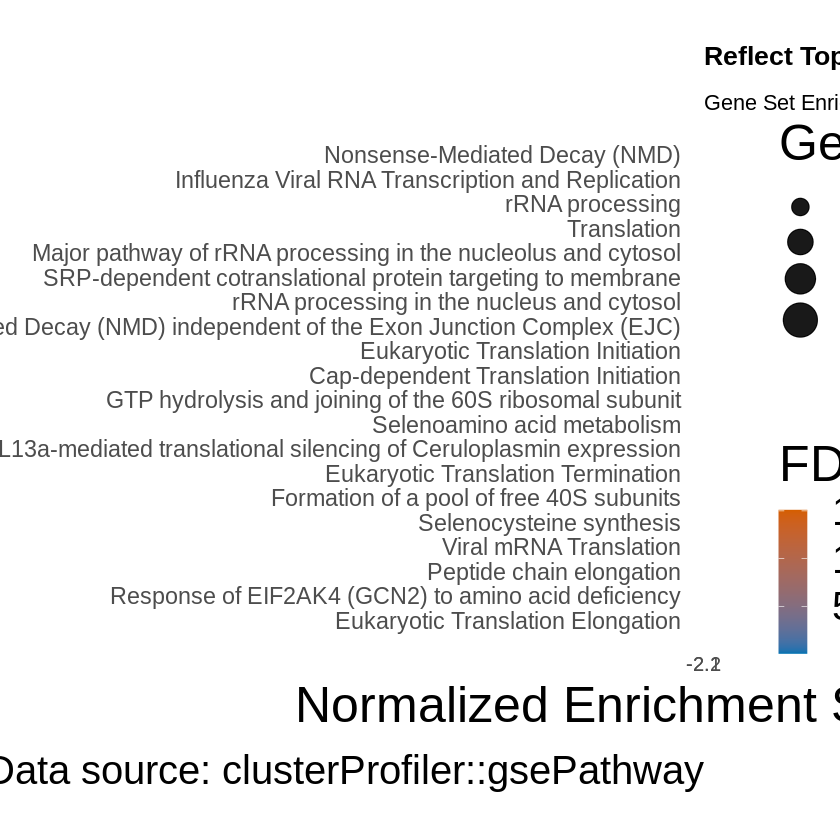

In [67]:
library(ggplot2)

r1 <- ggplot(top20, aes(x = NES,
                        y = Description,
                        color = p.adjust,
                        size = setSize)) +
  geom_point(alpha = 0.9) +
  scale_color_gradient(low = "#0072B2", high = "#D55E00", name = "FDR (p.adjust)") +
  scale_size(range = c(3, 10), name = "Gene Set Size") +
  labs(
    title = "Reflect Top 20 Enriched Pathways",
    subtitle = "Gene Set Enrichment Analysis (GSEA)",
    x = "Normalized Enrichment Score (NES)",
    y = NULL,
    caption = "Data source: clusterProfiler::gsePathway"
  ) +
  theme_minimal(base_size = 30) +
  theme(
    axis.text.y = element_text(size = 14),
    axis.text.x = element_text(size = 12),
    plot.title = element_text(face = "bold", size = 16),
    plot.subtitle = element_text(size = 13),
    legend.position = "right",
    plot.margin = unit(c(1, 1, 1, 1), "cm")
  )

print(r1)

ggsave("top_pathways_gsea_plot.png", plot = r1, width = 12, height = 10, dpi = 300)
ggsave("top_pathways_gsea_plot.pdf", plot = r1, width = 12, height = 10)

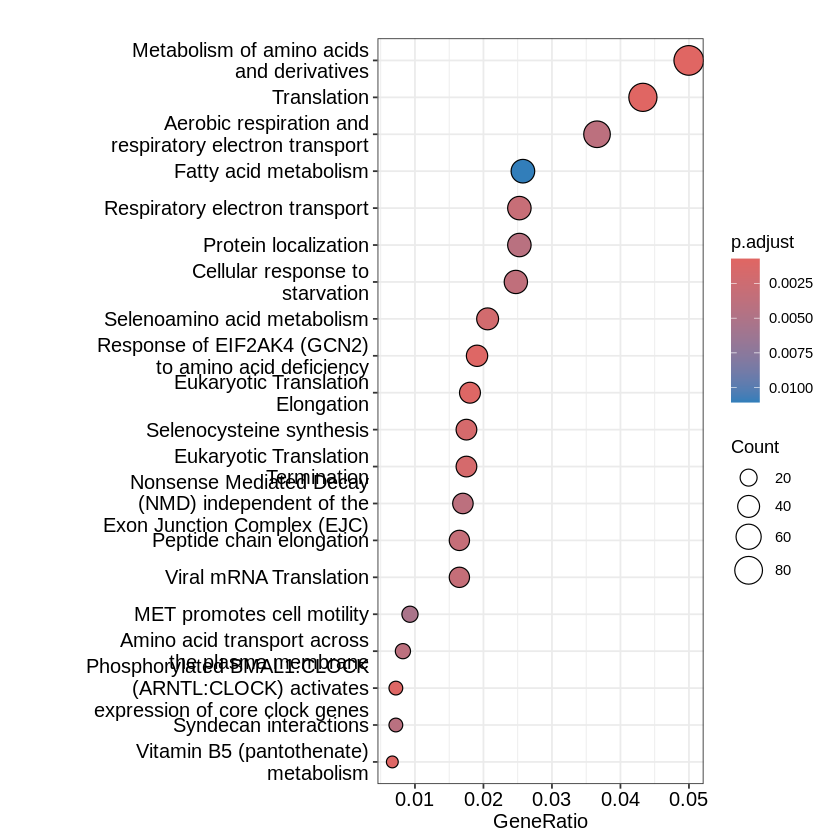

In [68]:
library(ReactomePA)
sig_genes <- res_mapped %>%
  filter(padj < 0.1, abs(log2FoldChange) > 0.5) %>%
  pull(ENTREZID)
enr <- enrichPathway(gene = sig_genes, organism = "human", pvalueCutoff = 0.1)
dotplot(enr, showCategory=20)

strong enrichment of amino acid metabolism and translation-related pathways, pointing towards metabolic stress and altered protein synthesis as key biological changes.

## PLOT COUNTS

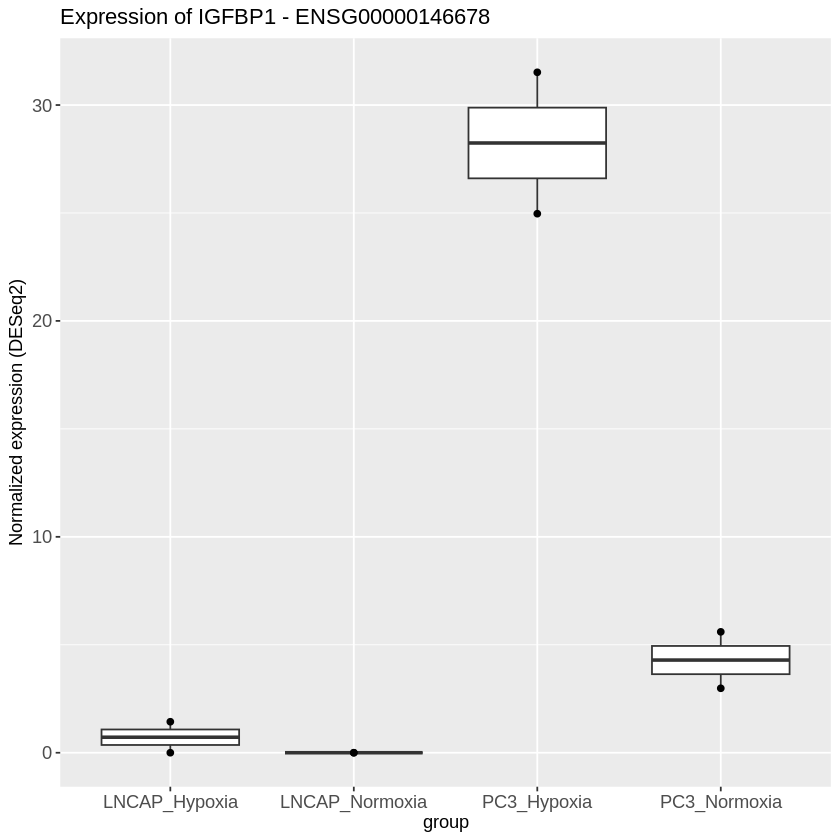

In [69]:
plot_counts <- function (dds, gene, normalization = "DESeq2"){
  annotation <- read.csv("/content/Gene_ann_GrCh38.p14.csv", header = T, stringsAsFactors = F)
  if (normalization == "cpm") {
    normalized_data <- cpm(counts(dds, normalized = F))
  } else if (normalization == "DESeq2")
    normalized_data <- counts(dds, normalized = T)
  condition <- dds@colData$condition
  if (is.numeric(gene)) {
    if (gene%%1==0 )
      ensembl_id <- rownames(normalized_data)[gene]
    else
      stop("Invalid index supplied.")
  } else if (gene %in% annotation$Gene.name){
    ensembl_id <- annotation$Gene.stable.ID[which(annotation$Gene.name == gene)]
  } else if (gene %in% annotation$Gene.stable.ID){
    ensembl_id <- gene
  } else {
    stop("Gene not found. Check spelling.")
  }
  expression <- normalized_data[ensembl_id,]
  gene_name <- annotation$Gene.name[which(annotation$Gene.stable.ID == ensembl_id)]
  gene_tib <- tibble(condition = condition, expression = expression)
  ggplot(gene_tib, aes(x = condition, y = expression))+
    geom_boxplot(outlier.size = NULL)+
    geom_point()+
    labs (title = paste0("Expression of ", gene_name, " - ", ensembl_id), x = "group", y = paste0("Normalized expression (", normalization , ")"))+
    theme(axis.text.x = element_text(size = 11), axis.text.y = element_text(size = 11))
}

plot_counts(dds, "IGFBP1")

We observe that IGFBP1 is elevated in the the hypoxia conditions relative to the respective normoxia controls. Interestingly, the upregulation of IGFBP1 is much higher in PC3 cells than in LNCaP cells.

## Hallmark analysis

 we have to rank every gene available in terms of how much higher or lower it is in group A vs group B. This is called a ranked list, and we have already generated one in the above section using the function generate_DE_results(). We can plug this ranked list the R package fgsea from Bioconductor

We also need to download the pathway files from the GSEA MSigDB webpage at: https://www.gsea-msigdb.org/gsea/msigdb/download_file.jsp?filePath=/msigdb/release/2025.1.Hs/h.all.v2025.1.Hs.symbols.gmt

Upload the file for the analysis (convert it to text before upload by just renaming and adding .txt at the end.

/content/h.all.v2025.1.Hs.symbols.gmt.txt

In [80]:
library(fgsea)
hallmark_pathway <- gmtPathways("/content/h.all.v2025.1.Hs.symbols.gmt.txt")
head(names(hallmark_pathway))
head(hallmark_pathway$HALLMARK_HYPOXIA, 20)


[1] "HALLMARK_ADIPOGENESIS"        "HALLMARK_ALLOGRAFT_REJECTION"
[3] "HALLMARK_ANDROGEN_RESPONSE"   "HALLMARK_ANGIOGENESIS"       
[5] "HALLMARK_APICAL_JUNCTION"     "HALLMARK_APICAL_SURFACE"

[1] "ACKR3"    "ADM"      "ADORA2B"  "AK4"      "AKAP12"   "ALDOA"   
 [7] "ALDOB"    "ALDOC"    "AMPD3"    "ANGPTL4"  "ANKZF1"   "ANXA2"   
[13] "ATF3"     "ATP7A"    "B3GALT6"  "B4GALNT2" "BCAN"     "BCL2"    
[19] "BGN"      "BHLHE40"

In [81]:
lncap_ranked_list <- read.table(
  "/content/LNCAP_Hypoxia_vs_LNCAP_Normoxia_rank.rnk",
  header = TRUE, sep = "\t", fill = TRUE, stringsAsFactors = FALSE
)

In [82]:
head(lncap_ranked_list)

,Gene.name,log2FoldChange
,<chr>,<dbl>
1,TGFB1,7.702373
2,GGTA1,7.283807
3,BEND5,7.102176
4,RXFP1,6.698880
5,FAM43B,6.633498
6,KRT72,6.524119


In [83]:
lncap_ranked_list <- lncap_ranked_list[complete.cases(lncap_ranked_list), ]

In [84]:
prepare_ranked_list <- function(ranked_list) {
  # if duplicate gene names present, average the values
  if( sum(duplicated(ranked_list$Gene.name)) > 0) {
    ranked_list <- aggregate(.~Gene.name, FUN = mean, data = ranked_list)
    ranked_list <- ranked_list[order(ranked_list$log2FoldChange, decreasing = T),]
  }
  # omit rows with values which are not available
  ranked_list <- na.omit(ranked_list)
  # turn the dataframe into a named vector
  ranked_list <- tibble::deframe(ranked_list)
  ranked_list
}

lncap_ranked_list <- prepare_ranked_list(lncap_ranked_list)
head(lncap_ranked_list)

TGFB1    GGTA1    BEND5    RXFP1   FAM43B    KRT72 
7.702373 7.283807 7.102176 6.698880 6.633498 6.524119

In [85]:
# removing any entries with missing or empty gene names
lncap_ranked_list <- lncap_ranked_list[!is.na(names(lncap_ranked_list)) & names(lncap_ranked_list) != ""]

In [86]:
head(lncap_ranked_list)

TGFB1    GGTA1    BEND5    RXFP1   FAM43B    KRT72 
7.702373 7.283807 7.102176 6.698880 6.633498 6.524119

In [88]:
# Generate GSEA results with ranked list
fgsea_results_lncap <- fgsea(pathways = hallmark_pathway,
                           stats = lncap_ranked_list,
                           minSize = 15,
                           maxSize = 500,
                           eps = 0)

# Arranging the results by Normalized Enrichment Score (NES) in descending order
fgsea_results_lncap %>%
  arrange(desc(NES)) %>%
  dplyr::select(pathway, padj, NES) %>%
  head()

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (11.21% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


pathway,padj,NES
<chr>,<dbl>,<dbl>
HALLMARK_HYPOXIA,6.168183e-11,2.174482
HALLMARK_ANDROGEN_RESPONSE,3.114865e-05,1.919603
HALLMARK_GLYCOLYSIS,1.945115e-05,1.808977
HALLMARK_ANGIOGENESIS,4.674036e-03,1.792321
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,3.114865e-05,1.785088
HALLMARK_TGF_BETA_SIGNALING,4.156623e-03,1.759802


The normalized enrichment scores (NES) tell us how much more enriched the pathway is in the hypoxia samples compared to the normoxia samples. As expected, we observe that the most enriched pathway in response to hypoxia is the HALLMARK_HYPOXIA pathway.

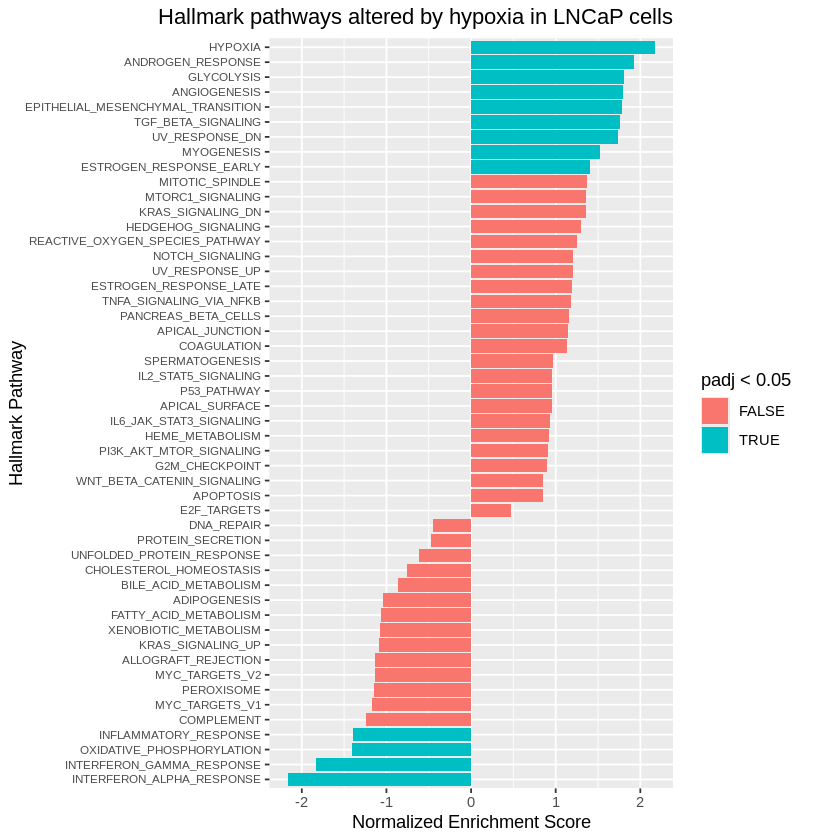

In [114]:
waterfall_plot <- function (fsgea_results_lncap, graph_title) {
  fgsea_results_lncap %>%
    mutate(short_name = str_split_fixed(pathway, "_",2)[,2])%>%
    ggplot( aes(reorder(short_name,NES), NES)) +
      geom_bar(stat= "identity", aes(fill = padj<0.05))+
      coord_flip()+
      labs(x = "Hallmark Pathway", y = "Normalized Enrichment Score", title = graph_title)+
      theme(axis.text.y = element_text(size = 7),
            plot.title = element_text(hjust = 1))
}
waterfall_plot(fgsea_results_lncap, "Hallmark pathways altered by hypoxia in LNCaP cells")

We can visualize the statistics for each pathway using a waterfall plot, which is a sideways bar plot of normalized enrichment scores for each of the pathways, color-coded by significance. This plot is great for quickly identifying the significantly enriched pathways.

This plot shows that hypoxia significantly upregulates glycolysis, angiogenesis, EMT, and androgen signaling while suppressing oxidative phosphorylation and interferon responses, highlighting metabolic reprogramming, invasive behavior, and immune evasion in LNCaP cells.

### PC3

In [139]:
pc3_ranked_list <- read.table(
  "/content/PC3_Hypoxia_vs_PC3_Normoxia_rank.rnk",
  header = TRUE, sep = "\t", fill = TRUE, stringsAsFactors = FALSE
)

pc3_ranked_list <- prepare_ranked_list(pc3_ranked_list)

# remove any entries with missing or empty gene names
pc3_ranked_list <- pc3_ranked_list[!is.na(names(pc3_ranked_list)) & names(pc3_ranked_list) != ""]

head(pc3_ranked_list)

ANGPTL4      CA9   EIF3CL   DCDC2C   SLAMF9   NKX2-1 
6.549559 6.248435 5.770774 5.290782 5.285210 5.257812

In [140]:
# Generate GSEA results with the ranked list
fgsea_results_pc3 <- fgsea(pathways = hallmark_pathway,
                           stats = pc3_ranked_list,
                           minSize = 15,
                           maxSize = 500,
                           eps = 0)

# Arranging the results by Normalized Enrichment Score (NES) in descending order
fgsea_results_pc3 %>%
  arrange(desc(NES)) %>%
  dplyr::select(pathway, padj, NES) %>%
  head()

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (13.03% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


pathway,padj,NES
<chr>,<dbl>,<dbl>
HALLMARK_HYPOXIA,6.859876e-29,2.836066
HALLMARK_GLYCOLYSIS,1.103204e-12,2.322128
HALLMARK_MTORC1_SIGNALING,3.054460e-06,1.888646
HALLMARK_UV_RESPONSE_DN,2.159811e-03,1.700078
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,2.159811e-03,1.617620
HALLMARK_TNFA_SIGNALING_VIA_NFKB,2.159811e-03,1.585741


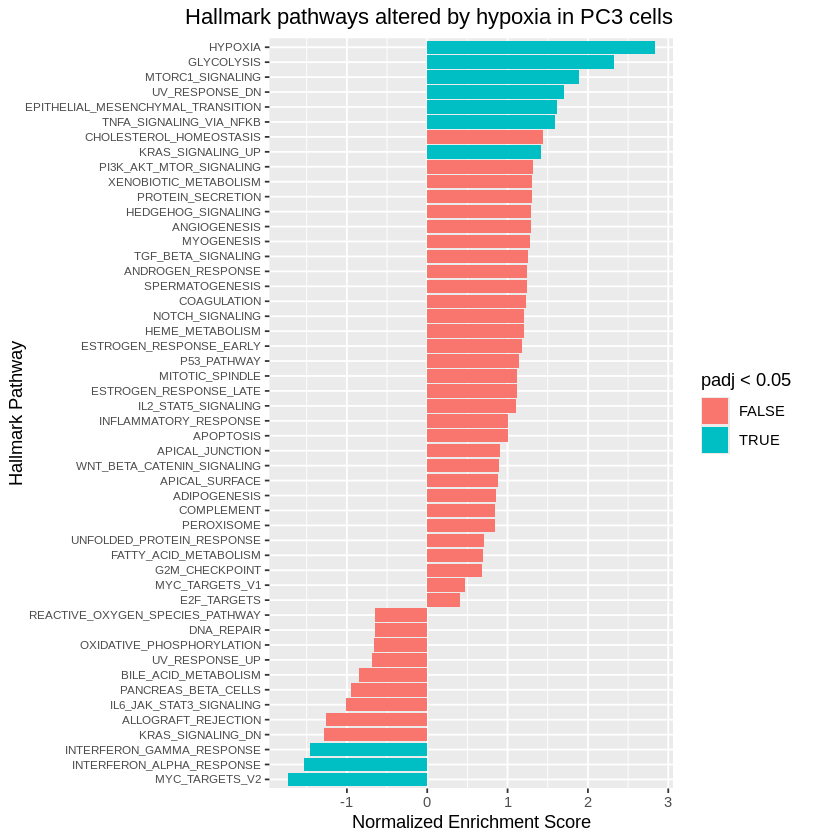

In [142]:
waterfall_plot <- function (fgsea_results_pc3, graph_title) {
  fgsea_results_pc3 %>%
    mutate(short_name = str_split_fixed(pathway, "_",2)[,2])%>%
    ggplot( aes(reorder(short_name,NES), NES)) +
      geom_bar(stat= "identity", aes(fill = padj<0.05))+
      coord_flip()+
      labs(x = "Hallmark Pathway", y = "Normalized Enrichment Score", title = graph_title)+
      theme(axis.text.y = element_text(size = 7),
            plot.title = element_text(hjust = 1))
}
waterfall_plot(fgsea_results_pc3, "Hallmark pathways altered by hypoxia in PC3 cells")

Under hypoxia, PC3 cells upregulate glycolysis, mTORC1 signaling, and EMT while suppressing interferon responses, indicating a metabolic and oncogenic adaptation favoring survival and immune evasion. Compared to LNCaP, PC3 cells depend more on growth factor pathways and less on androgen signaling under hypoxia.

# Conclusion

LNCaP and PC3 cells show very different overall gene expression patterns, but they share a common response to hypoxia. In both cell lines, hypoxia increases genes linked to glycolysis and decreases genes linked to oxidative phosphorylation, showing a clear metabolic switch. LNCaP cells mainly activate androgen signaling and angiogenesis, while PC3 cells rely more on mTORC1 and KRAS signaling along with immune suppression to adapt to low oxygen

With this the main analysis ends. All the results will be saved in the output folder. the ones in the notebook can be downloaded by saving the image from the output window.

I had fun learning the DESeq2 with bulk RNAseq, Thanks to mentor Smriti for guiding through the process.

# Extras

These are some work which are not part of the main analysis, just to find any different ways to do.

## Identify common upregulated genes

Filtering the results from both LNCaP and PC3 analyses to find genes that are significantly upregulated in both cell lines under hypoxia.


In [118]:
# Filtering LNCaP results for significant upregulation
lncap_upregulated_genes <- reslncapOrdered %>%
  filter(padj < 0.05 & log2FoldChange > 0) %>%
  rownames()

# Filtering PC3 results for significant upregulation
pc3_upregulated_genes <- res_pc3_df %>%
  filter(padj < 0.05 & log2FoldChange > 0) %>%
  rownames()

# intersection of the two vectors of gene IDs
common_upregulated_genes <- intersect(lncap_upregulated_genes, pc3_upregulated_genes)


common_upregulated_df <- reslncapOrdered[common_upregulated_genes, ] %>%
  dplyr::select(baseMean_lncap = baseMean, log2FoldChange_lncap = log2FoldChange, padj_lncap = padj)

# PC3 specific columns by matching rownames
common_upregulated_df$baseMean_pc3 <- res_pc3_df[rownames(common_upregulated_df), "baseMean"]
common_upregulated_df$log2FoldChange_pc3 <- res_pc3_df[rownames(common_upregulated_df), "log2FoldChange"]
common_upregulated_df$padj_pc3 <- res_pc3_df[rownames(common_upregulated_df), "padj"]

# Gene Name and Gene Type from the annotation file
common_upregulated_df$Gene.name <- annotation$Gene.name[match(rownames(common_upregulated_df), annotation$Gene.stable.ID)]
common_upregulated_df$Gene.type <- annotation$Gene.type[match(rownames(common_upregulated_df), annotation$Gene.stable.ID)]


common_upregulated_df <- common_upregulated_df %>%
  rownames_to_column("Geneid")

common_upregulated_df <- common_upregulated_df %>%
  dplyr::select(Geneid, Gene.name, Gene.type,
                baseMean_lncap, log2FoldChange_lncap, padj_lncap,
                baseMean_pc3, log2FoldChange_pc3, padj_pc3)

head(common_upregulated_df)

,Geneid,Gene.name,Gene.type,baseMean_lncap,log2FoldChange_lncap,padj_lncap,baseMean_pc3,log2FoldChange_pc3,padj_pc3
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000152952,PLOD2,protein_coding,5219.120,5.636692,0.000000e+00,7246.5495,2.1984753,5.959133e-113
2,ENSG00000159167,STC1,protein_coding,1619.018,5.468060,8.852723e-294,5843.8971,3.1290519,3.846968e-251
3,ENSG00000131016,AKAP12,protein_coding,2300.769,3.741240,1.431480e-190,2158.0890,1.7155229,8.381133e-56
4,ENSG00000104419,NDRG1,protein_coding,15547.804,2.992616,1.615173e-152,76218.6718,4.5250705,0.000000e+00
5,ENSG00000137801,THBS1,protein_coding,1841.460,3.578950,4.527231e-134,3914.8005,0.8243753,2.885727e-02
6,ENSG00000143847,PPFIA4,protein_coding,829.833,4.127502,7.353666e-129,227.9705,3.8184437,5.049389e-29


In [119]:
# Filter LNCaP results for significant downregulation
lncap_downregulated_genes <- reslncapOrdered %>%
  filter(padj < 0.05 & log2FoldChange < 0) %>%
  rownames()

# Filter PC3 results for significant downregulation
pc3_downregulated_genes <- res_pc3_df %>%
  filter(padj < 0.05 & log2FoldChange < 0) %>%
  rownames()

# intersection of the two vectors of gene IDs
common_downregulated_genes <- intersect(lncap_downregulated_genes, pc3_downregulated_genes)

common_downregulated_df <- reslncapOrdered[common_downregulated_genes, ] %>%
  dplyr::select(baseMean_lncap = baseMean, log2FoldChange_lncap = log2FoldChange, padj_lncap = padj)

# Add PC3 specific columns by matching rownames
common_downregulated_df$baseMean_pc3 <- res_pc3_df[rownames(common_downregulated_df), "baseMean"]
common_downregulated_df$log2FoldChange_pc3 <- res_pc3_df[rownames(common_downregulated_df), "log2FoldChange"]
common_downregulated_df$padj_pc3 <- res_pc3_df[rownames(common_downregulated_df), "padj"]

# Add annotation file
common_downregulated_df$Gene.name <- annotation$Gene.name[match(rownames(common_downregulated_df), annotation$Gene.stable.ID)]
common_downregulated_df$Gene.type <- annotation$Gene.type[match(rownames(common_downregulated_df), annotation$Gene.stable.ID)]


common_downregulated_df <- common_downregulated_df %>%
  rownames_to_column("Geneid")

# reordeing column
common_downregulated_df <- common_downregulated_df %>%
  dplyr::select(Geneid, Gene.name, Gene.type,
                baseMean_lncap, log2FoldChange_lncap, padj_lncap,
                baseMean_pc3, log2FoldChange_pc3, padj_pc3)


head(common_downregulated_df)

,Geneid,Gene.name,Gene.type,baseMean_lncap,log2FoldChange_lncap,padj_lncap,baseMean_pc3,log2FoldChange_pc3,padj_pc3
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000198763,MT-ND2,protein_coding,97439.52,-1.876062,1.613035e-80,78215.61,-1.0676874,3.849595e-22
2,ENSG00000198727,MT-CYB,protein_coding,130870.92,-1.581825,4.763115e-58,73687.43,-0.8710786,9.881770e-19
3,ENSG00000198888,MT-ND1,protein_coding,113278.88,-1.664692,2.219638e-49,56946.83,-0.9135750,5.032753e-16
4,ENSG00000198840,MT-ND3,protein_coding,27942.52,-1.439448,5.447788e-46,17561.93,-0.8005526,5.549567e-18
5,ENSG00000198938,MT-CO3,protein_coding,162912.13,-1.215501,2.103740e-34,167288.66,-0.6049847,1.507519e-12
6,ENSG00000212907,MT-ND4L,protein_coding,53639.15,-1.131856,1.670227e-26,19742.19,-0.4356714,8.324836e-07


## Scatter plot of log2 fold changes for common differentially expressed genes

Warning message:
“ggrepel: 1194 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 809 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


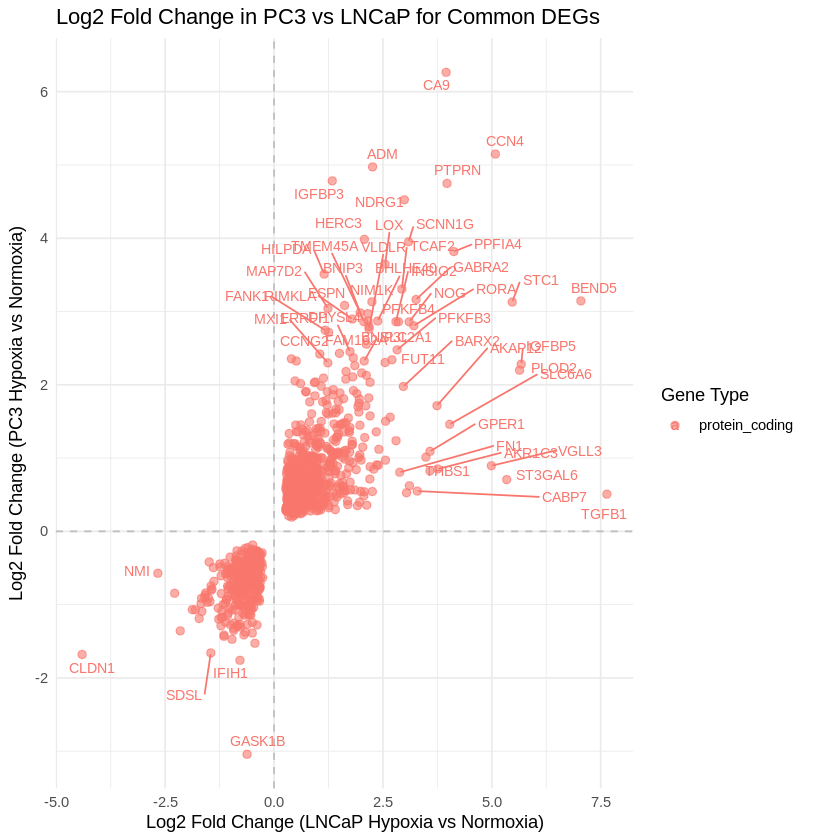

In [79]:
all_common_df <- rbind(common_upregulated_df, common_downregulated_df)


scatter_plot <- ggplot(all_common_df, aes(x = log2FoldChange_lncap, y = log2FoldChange_pc3, color = Gene.type)) +
  geom_point(alpha = 0.6, size = 2) +
  geom_vline(xintercept = 0, linetype = "dashed", color = "grey") +
  geom_hline(yintercept = 0, linetype = "dashed", color = "grey") +
  labs(title = "Log2 Fold Change in PC3 vs LNCaP for Common DEGs",
       x = "Log2 Fold Change (LNCaP Hypoxia vs Normoxia)",
       y = "Log2 Fold Change (PC3 Hypoxia vs Normoxia)",
       color = "Gene Type") +
  theme_minimal() +
  ggrepel::geom_text_repel(aes(label = Gene.name), size = 3, max.overlaps = 30)


print(scatter_plot)


ggsave("common_degs_scatter_plot.png", plot = scatter_plot, width = 20, height = 30, dpi = 300)

In [75]:
fwrite(common_upregulated_df, file = "common_upregulated_genes.csv", sep = ",", row.names = FALSE)
fwrite(common_downregulated_df, file = "common_downregulated_genes.csv", sep = ",", row.names = FALSE)

## Compare the log2 fold change of both cell lines in hypoxia and normoxia condition.

## Subset data for hypoxia condition

Create a new DESeqDataSet object containing only the samples from the hypoxia condition (LNCaP Hypoxia and PC3 Hypoxia).


In [122]:
dds_hypoxia <- dds[, grepl("Hypoxia", colnames(dds))]
dds_hypoxia$condition <- droplevels(dds_hypoxia$condition)
dds_hypoxia$condition <- relevel(dds_hypoxia$condition, ref = "LNCAP_Hypoxia")
dds_hypoxia

class: DESeqDataSet 
dim: 17551 4 
metadata(1): version
assays(4): counts mu H cooks
rownames(17551): ENSG00000000003 ENSG00000000419 ... ENSG00000310560
  ENSG00000310576
rowData names(30): baseMean baseVar ... deviance maxCooks
colnames(4): LNCAP_Hypoxia_S1 LNCAP_Hypoxia_S2 PC3_Hypoxia_S1
  PC3_Hypoxia_S2
colData names(2): condition sizeFactor

## deseq2 for hypoxia

Performing differential expression analysis on the hypoxia dataset to identify differentially expressed genes between LNCaP and PC3 under hypoxia.


In [123]:
dds_hypoxia <- DESeq(dds_hypoxia)
res_hypoxia <- results(dds_hypoxia, contrast = c("condition", "PC3_Hypoxia", "LNCAP_Hypoxia"))
summary(res_hypoxia)

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing




out of 17381 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 6137, 35%
LFC < 0 (down)     : 5967, 34%
outliers [1]       : 0, 0%
low counts [2]     : 1347, 7.7%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [124]:
res_hypoxia_df <- as.data.frame(res_hypoxia)

res_hypoxia_df <- res_hypoxia_df[order(res_hypoxia_df$padj), ]

res_hypoxia_df$Gene.name <- annotation$Gene.name[match(rownames(res_hypoxia_df), annotation$Gene.stable.ID)]
res_hypoxia_df$Gene.type <- annotation$Gene.type[match(rownames(res_hypoxia_df), annotation$Gene.stable.ID)]

head(res_hypoxia_df)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Gene.name,Gene.type
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ENSG00000005884,4884.742,4.763886,0.10280008,46.34126,0,0,ITGA3,protein_coding
ENSG00000012660,50988.626,-3.516973,0.07903228,-44.50046,0,0,ELOVL5,protein_coding
ENSG00000020577,3317.255,6.398569,0.13390417,47.78469,0,0,SAMD4A,protein_coding
ENSG00000026025,9036.351,4.104879,0.08199427,50.06300,0,0,VIM,protein_coding
ENSG00000026508,11886.955,11.695732,0.28613020,40.87556,0,0,CD44,protein_coding
ENSG00000029153,3615.866,4.205202,0.09947523,42.27386,0,0,BMAL2,protein_coding


## Subset data for normoxia condition


Create a new DESeqDataSet object containing only the samples from the normoxia condition (LNCaP Normoxia and PC3 Normoxia).

In [125]:
dds_normoxia <- dds[, grepl("Normoxia", colnames(dds))]
dds_normoxia$condition <- droplevels(dds_normoxia$condition)
dds_normoxia$condition <- relevel(dds_normoxia$condition, ref = "LNCAP_Normoxia")
dds_normoxia

class: DESeqDataSet 
dim: 17551 4 
metadata(1): version
assays(4): counts mu H cooks
rownames(17551): ENSG00000000003 ENSG00000000419 ... ENSG00000310560
  ENSG00000310576
rowData names(30): baseMean baseVar ... deviance maxCooks
colnames(4): LNCAP_Normoxia_S1 LNCAP_Normoxia_S2 PC3_Normoxia_S1
  PC3_Normoxia_S2
colData names(2): condition sizeFactor

## deseq2 for normoxia

Performing differential expression analysis on the normoxia dataset to identify differentially expressed genes between LNCaP and PC3 under normoxia.


In [126]:
dds_normoxia <- DESeq(dds_normoxia)
res_normoxia <- results(dds_normoxia, contrast = c("condition", "PC3_Normoxia", "LNCAP_Normoxia"))
summary(res_normoxia)

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing




out of 17450 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 5801, 33%
LFC < 0 (down)     : 5743, 33%
outliers [1]       : 0, 0%
low counts [2]     : 1009, 5.8%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [127]:
res_normoxia_df <- as.data.frame(res_normoxia)
res_normoxia_df <- res_normoxia_df[order(res_normoxia_df$padj), ]

# Adding Gene.name and Gene.type columns
res_normoxia_df$Gene.name <- annotation$Gene.name[match(rownames(res_normoxia_df), annotation$Gene.stable.ID)]
res_normoxia_df$Gene.type <- annotation$Gene.type[match(rownames(res_normoxia_df), annotation$Gene.stable.ID)]

head(res_normoxia_df)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Gene.name,Gene.type
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ENSG00000039068,7868.524,-6.576860,0.1584356,-41.51125,0,0,CDH1,protein_coding
ENSG00000057019,23715.511,7.809364,0.1304154,59.88068,0,0,DCBLD2,protein_coding
ENSG00000064042,12831.974,-6.673635,0.1527196,-43.69860,0,0,LIMCH1,protein_coding
ENSG00000103044,2474.473,6.588246,0.1686236,39.07073,0,0,HAS3,protein_coding
ENSG00000115053,23301.951,-6.221114,0.1304341,-47.69547,0,0,NCL,protein_coding
ENSG00000120885,3726.643,5.066608,0.1316382,38.48890,0,0,CLU,protein_coding


## Compareing log2 fold changes

Comparing the log2 fold changes obtained from the differential expression analysis of LNCaP vs PC3 under hypoxia and LNCaP vs PC3 under normoxia.


Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”
Warning message:
“ggrepel: 5730 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”
Warning message:
“ggrepel: 5628 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”
Warning message:
“ggrepel: 5657 unlabeled data points (too many overlaps). Consider increasing 

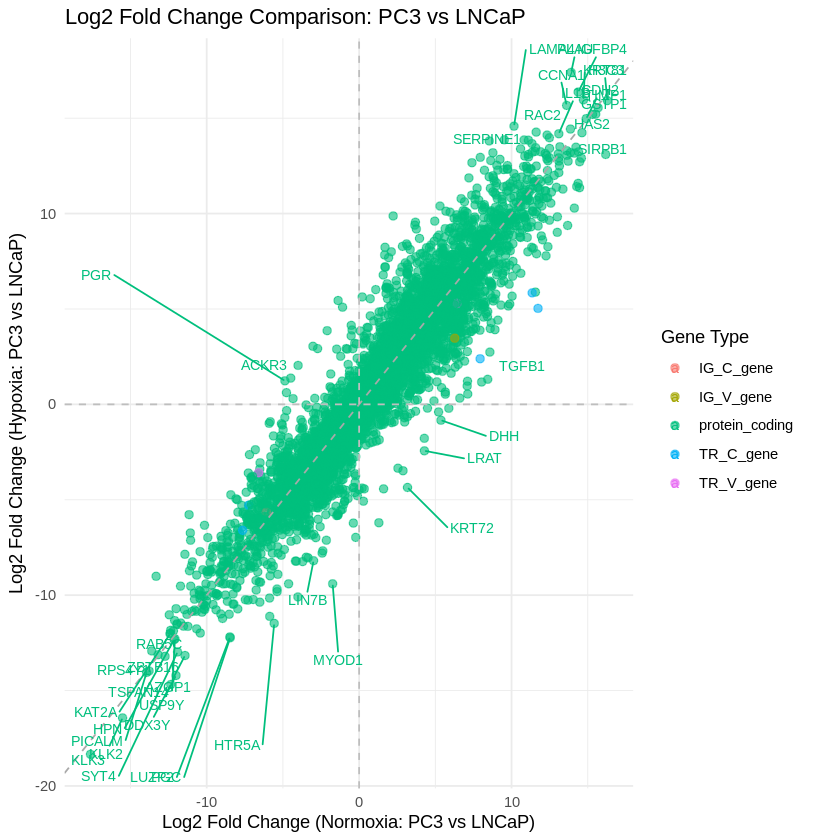

In [129]:
merged_de_results <- merge(res_hypoxia_df, res_normoxia_df, by = 0, suffixes = c("_hypoxia", "_normoxia")) %>%
  dplyr::rename(Geneid = `Row.names`)

# annotation
merged_de_results$Gene.name <- annotation$Gene.name[match(merged_de_results$Geneid, annotation$Gene.stable.ID)]
merged_de_results$Gene.type <- annotation$Gene.type[match(merged_de_results$Geneid, annotation$Gene.stable.ID)]


# Filter for significantly differentially expressed genes in at least one condition
significant_merged_de_results <- merged_de_results %>%
  filter(padj_hypoxia < 0.05 | padj_normoxia < 0.05)

# scatter plot
scatter_plot_comparison <- ggplot(significant_merged_de_results, aes(x = log2FoldChange_normoxia, y = log2FoldChange_hypoxia, color = Gene.type)) +
  geom_point(alpha = 0.6, size = 2) +
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "darkgrey") +
  geom_vline(xintercept = 0, linetype = "dashed", color = "grey") +
  geom_hline(yintercept = 0, linetype = "dashed", color = "grey") +
  labs(title = "Log2 Fold Change Comparison: PC3 vs LNCaP",
       x = "Log2 Fold Change (Normoxia: PC3 vs LNCaP)",
       y = "Log2 Fold Change (Hypoxia: PC3 vs LNCaP)",
       color = "Gene Type") +
  theme_minimal() +
  ggrepel::geom_text_repel(data = subset(significant_merged_de_results, abs(log2FoldChange_normoxia) > 2 | abs(log2FoldChange_hypoxia) > 2 | (abs(log2FoldChange_normoxia - log2FoldChange_hypoxia) > 1 & (padj_hypoxia < 0.01 | padj_normoxia < 0.01))),
                           aes(label = Gene.name), size = 3, max.overlaps = 50)


print(scatter_plot_comparison)

ggsave("log2FC_comparison_scatter.png", plot = scatter_plot_comparison, width = 10, height = 8, dpi = 300)
ggsave("log2FC_comparison_scatter.pdf", plot = scatter_plot_comparison, width = 10, height = 8)

## Summary:

### Data Analysis Key Findings

*   Differential expression analysis was successfully performed for PC3 vs LNCaP comparison under both hypoxia and normoxia conditions.
*   Under hypoxia, 6137 genes were upregulated and 5967 genes were downregulated in PC3 compared to LNCaP (adjusted p-value < 0.1).
*   Under normoxia, 5801 genes were upregulated and 5743 genes were downregulated in PC3 compared to LNCaP (adjusted p-value < 0.1).
*   A scatter plot comparing the log2 fold changes of genes significant in at least one condition showed the relationship between differential expression in hypoxia and normoxia for the PC3 vs LNCaP comparison.

